# Modelos de Regresión Lineal

## Análisis Exploratorio de Datos 

### Carga del dataset

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_file_path = "data/train_set.csv"
df_train = pd.read_csv(train_file_path)

In [4]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


In [5]:
print(f"El dataset contiene {df_train.shape[0]} filas y {df_train.shape[1]} columnas.")

El dataset contiene 1168 filas y 80 columnas.


### Limpieza de datos

Manejo de Valores Nulos - Se  obtienen la cantidad de valores nulos y el porcentaje para determinar que datos se pueden eliminar y como manejar aquellos que representan una gran porcion de los datos

In [6]:
def relevant_null_value_percentage(df, umbral):
    na_not_missing = [
        "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
        "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
        "PoolQC", "Fence", "MiscFeature"
    ]
    df_cleaning = df.isnull().sum().reset_index()
    df_cleaning.columns = ["Columnas", "Valores Nulos"]
    df_cleaning["Porcentaje de Valores Nulos"] = (df_cleaning["Valores Nulos"] / len(df)) * 100
    df_cleaning["Tipo de Nulo"] = df_cleaning["Columnas"].apply(
        lambda x: "No Aplica" if x in na_not_missing else "Dato Faltante"
    )
    df_cleaning = df_cleaning[df_cleaning["Porcentaje de Valores Nulos"] > umbral]
    df_cleaning = df_cleaning.sort_values(by="Porcentaje de Valores Nulos", ascending=False)

    return df_cleaning

In [7]:
df_nulos = relevant_null_value_percentage(df_train, 0)
print(df_nulos)

        Columnas  Valores Nulos  Porcentaje de Valores Nulos   Tipo de Nulo
71        PoolQC           1162                    99.486301      No Aplica
73   MiscFeature           1122                    96.061644      No Aplica
5          Alley           1094                    93.664384      No Aplica
72         Fence            935                    80.051370      No Aplica
24    MasVnrType            683                    58.476027  Dato Faltante
56   FireplaceQu            547                    46.832192      No Aplica
2    LotFrontage            217                    18.578767  Dato Faltante
57    GarageType             64                     5.479452      No Aplica
58   GarageYrBlt             64                     5.479452  Dato Faltante
59  GarageFinish             64                     5.479452      No Aplica
62    GarageQual             64                     5.479452      No Aplica
63    GarageCond             64                     5.479452      No Aplica
30      Bsmt

Para los columnas que presenten un porcentaje a 5% se deben trabajar los datos y para aquellas con un porcentaje menor a 5% se pueden eliminar esas filas con los datos nulos.

In [8]:
df_train_cleaned = df_train.copy()
# 1. Manejo de valores en MasVnrType con la moda (valor más frecuente)
mode_masvnrtype = df_train_cleaned["MasVnrType"].mode()[0]  # Obtener la moda
df_train_cleaned.loc[:, "MasVnrType"] = df_train_cleaned["MasVnrType"].fillna(mode_masvnrtype)

# 2. Manejo de  valores en LotFrontage con la mediana por Neighborhood
df_train_cleaned.loc[:, "LotFrontage"] = df_train_cleaned.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# 3. Imputar valores en GarageYrBlt con YearBuilt
df_train_cleaned.loc[:, "GarageYrBlt"] = df_train_cleaned["GarageYrBlt"].fillna(df_train_cleaned["YearBuilt"])

missing_after_imputation = df_train_cleaned[["MasVnrType", "LotFrontage", "GarageYrBlt"]].isnull().sum()

In [9]:
print("Valores nulos después de la imputación:")
print(missing_after_imputation)

Valores nulos después de la imputación:
MasVnrType     0
LotFrontage    0
GarageYrBlt    0
dtype: int64


Eliminar filas con valores null (menores al 5%)

In [10]:
df_train_cleaned = df_train_cleaned.dropna()
missing_after_drop = df_train_cleaned.isnull().sum()

In [11]:
print("Valores nulos después de eliminar filas con datos faltantes:")
print(missing_after_drop)

Valores nulos después de eliminar filas con datos faltantes:
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64


Transformación de variables categóricas

In [12]:
# 1. Identificar variables categóricas
categorical_vars = df_train.select_dtypes(include=['object']).columns

# 2. Decidir el tipo de transformación
# Label Encoding para variables con orden lógico
label_enc_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                  'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# One-Hot Encoding para el resto
one_hot_enc_vars = [col for col in categorical_vars if col not in label_enc_vars]

# 3. Aplicar Label Encoding
label_encoders = {}
for col in label_enc_vars:
    le = LabelEncoder()
    # Convertimos a string para evitar problemas con NaN
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    label_encoders[col] = le

# 4. Aplicar One-Hot Encoding
df_train_one_hot_encoded = pd.get_dummies(df_train[one_hot_enc_vars])

# 5. Unir los resultados al conjunto de datos original
df_train_transformed = pd.concat([df_train.drop(columns=one_hot_enc_vars), df_train_one_hot_encoded], axis=1)

# Resultados
{

    "Total de Columnas Después de Transformación": df_train_transformed.shape[1]
}


{'Total de Columnas Después de Transformación': 252}

Identificación de outliers y manejo de los mismos

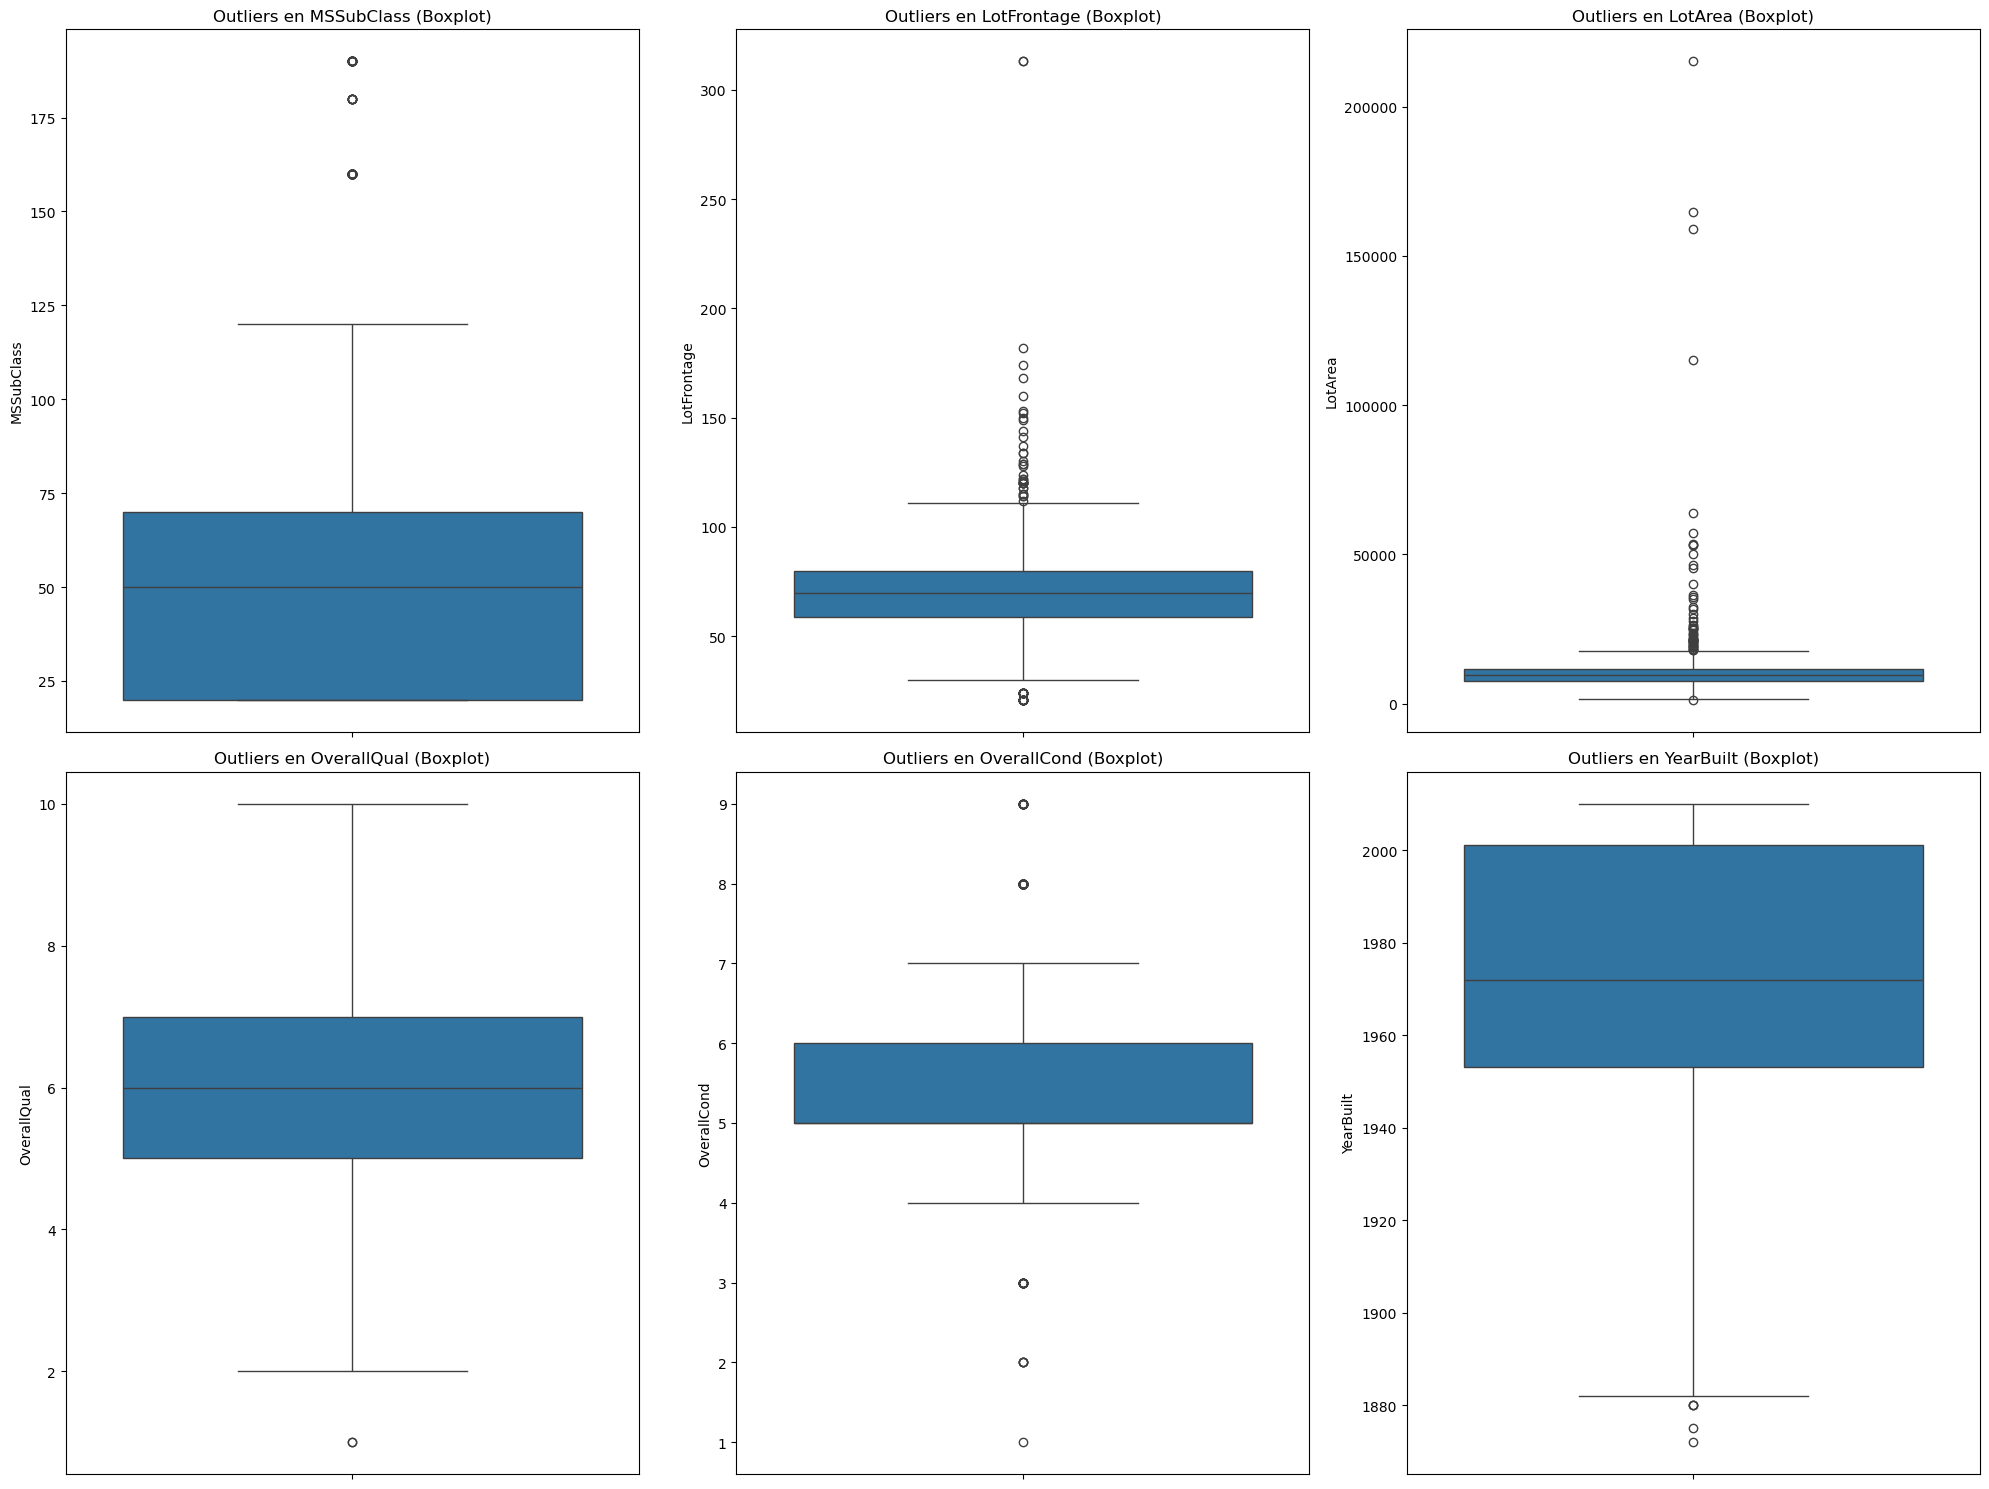

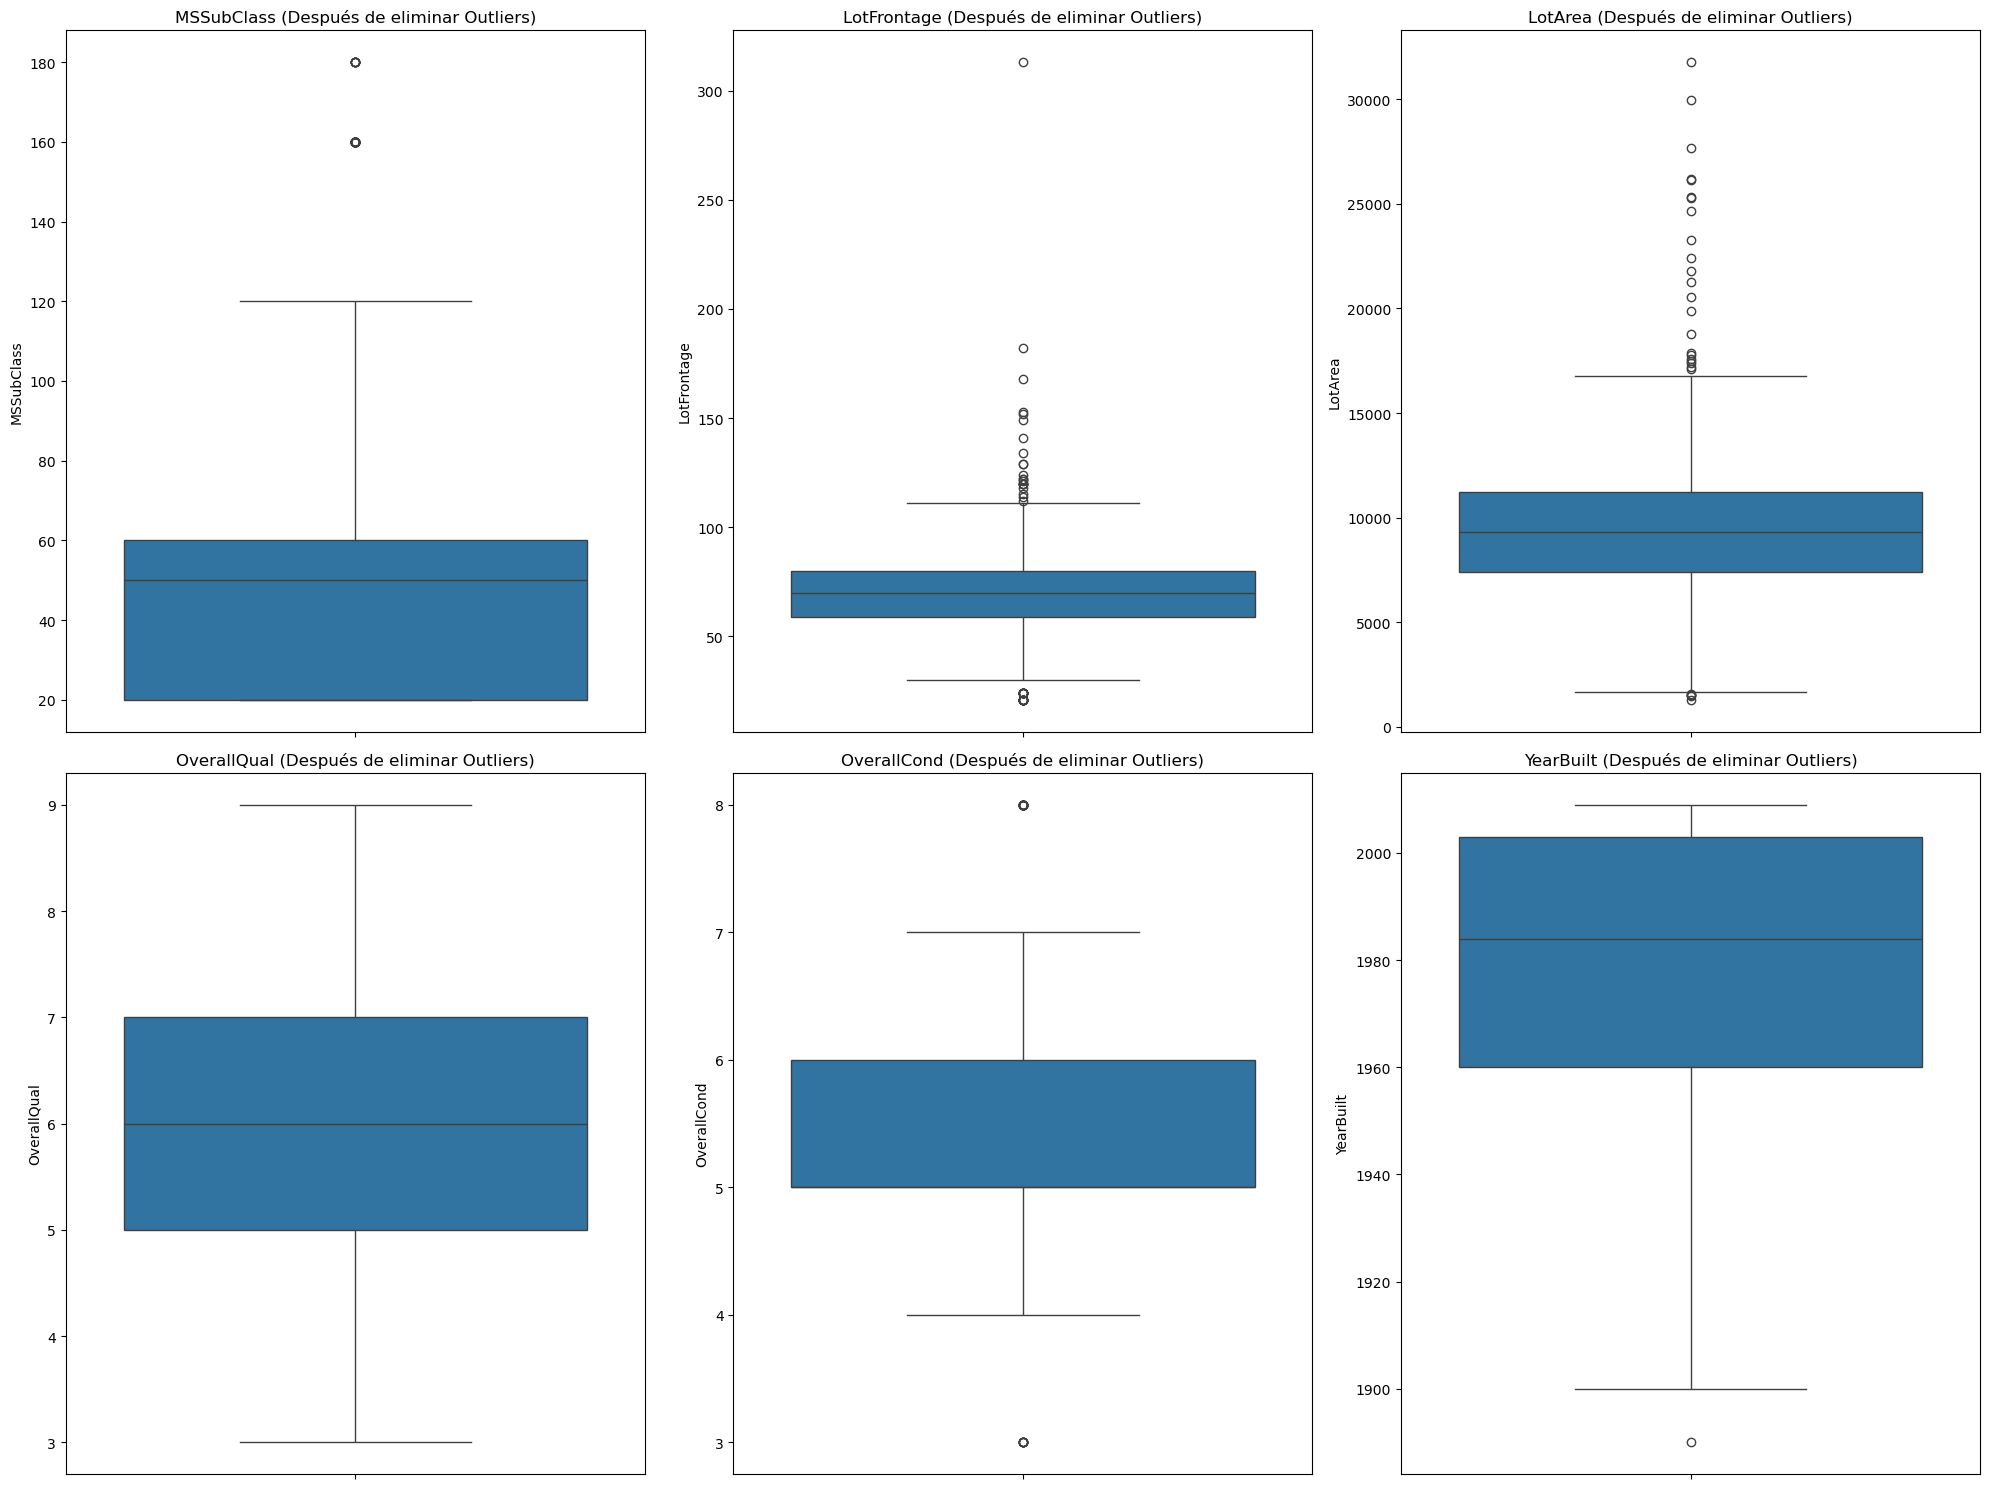

{'Total Outliers Identificados': 442,
 'Total Filas antes de limpiar': 1168,
 'Total Filas después de limpiar': 726}

In [13]:
from scipy.stats import zscore

# 1. Visualización de Outliers usando Boxplot
numerical_vars = df_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_train[col])
    plt.title(f'Outliers en {col} (Boxplot)')
plt.tight_layout()
plt.show()

# 2. Identificación de Outliers usando Z-score
outliers = {}
for col in numerical_vars:
    z_scores = zscore(df_train[col].dropna())
    outliers[col] = np.where(np.abs(z_scores) > 3)[0]  # Z-score > 3 se considera outlier

# 3. Manejo de Outliers: Remover outliers extremos (Z-score > 3)
# Concatenar todos los índices de outliers
all_outliers = np.concatenate(list(outliers.values()))
unique_outliers = np.unique(all_outliers)  # Evitar duplicados

# Remover outliers manteniendo los índices originales
df_train_cleaned = df_train.drop(index=unique_outliers)

# 4. Visualización después del manejo de outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_train_cleaned[col])
    plt.title(f'{col} (Después de eliminar Outliers)')
plt.tight_layout()
plt.show()

# Resultados
{
    "Total Outliers Identificados": len(unique_outliers),
    "Total Filas antes de limpiar": len(df_train),
    "Total Filas después de limpiar": len(df_train_cleaned)
}


*Los boxplots nos muestran:*

* La distribución de cada variable después de eliminar outliers.
* Los valores atípicos restantes (puntos fuera de los "bigotes").
* El impacto de la eliminación de outliers.

*Observando los boxplots:*

* Variables como MSSubClass y OverallCond ya no tienen outliers extremos, lo que sugiere que la limpieza de datos fue efectiva.
* Variables como LotFrontage y LotArea siguen mostrando valores extremos, lo que indica que:
    * Hay casas con lotes mucho más grandes de lo normal.
    * No necesariamente son errores, sino valores legítimos de casas muy grandes.

Estandarizació o normalización de variables en base a demnadas.

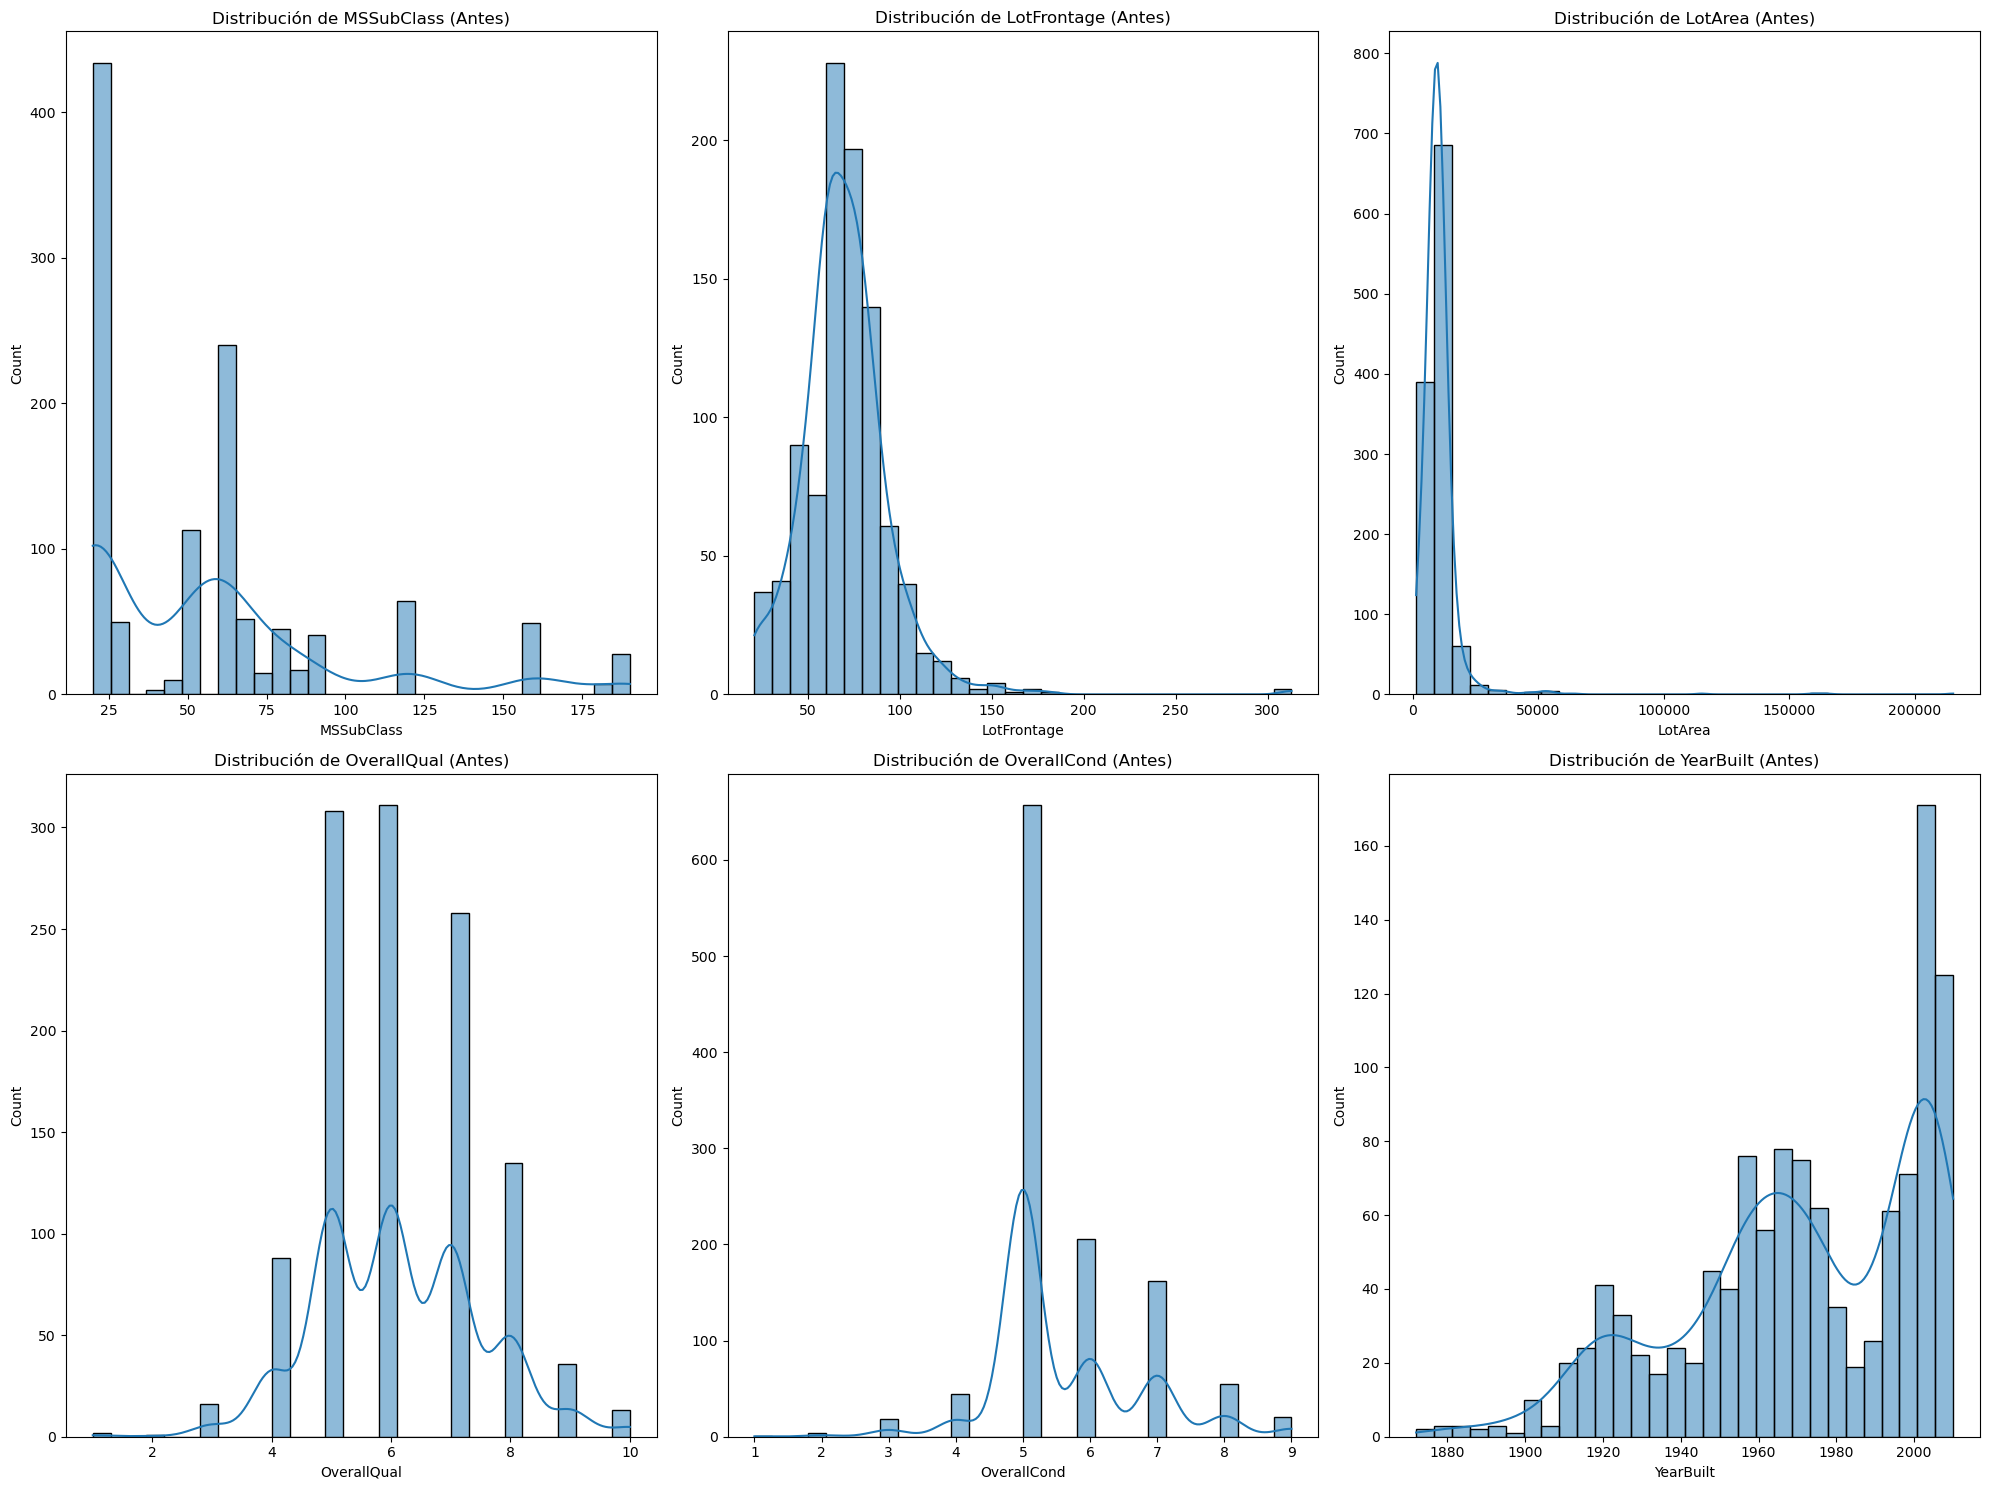

In [14]:
# 1. Análisis de Distribución de Variables Numéricas
numerical_vars = df_train_transformed.select_dtypes(include=['int64', 'float64']).columns

# Visualización de distribuciones antes de la transformación
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_transformed[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribución de {col} (Antes)')
plt.tight_layout()
plt.show()

# 2. Estandarización y Normalización en base a la distribución
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()



Cada gráfico representa la distribución de una variable numérica en el dataset antes de la transformación.

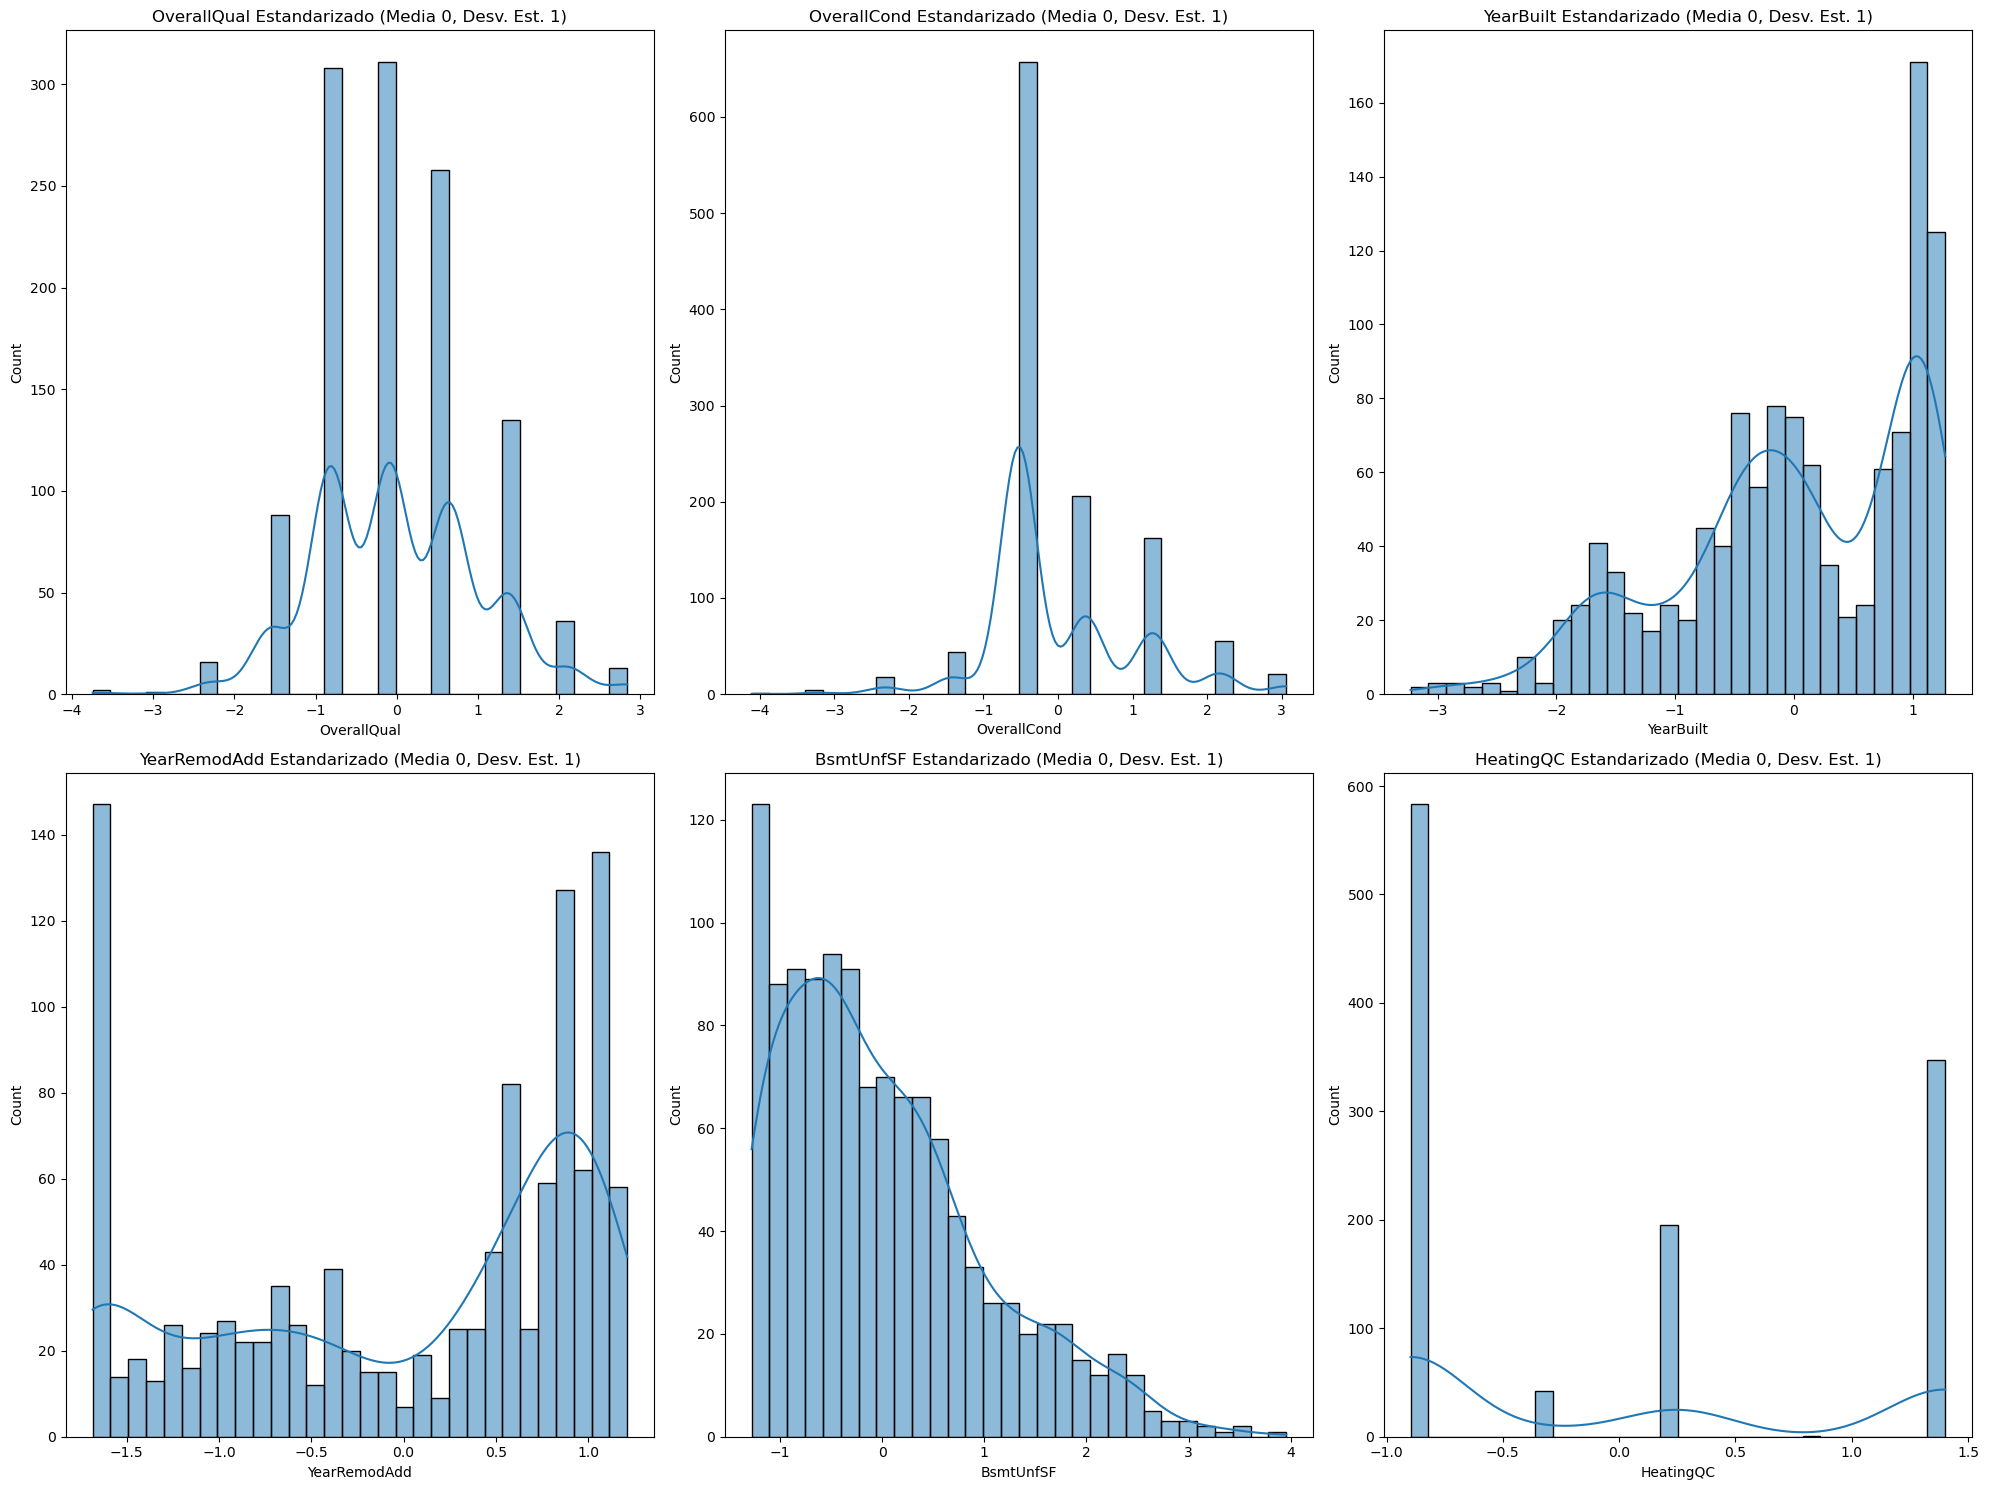

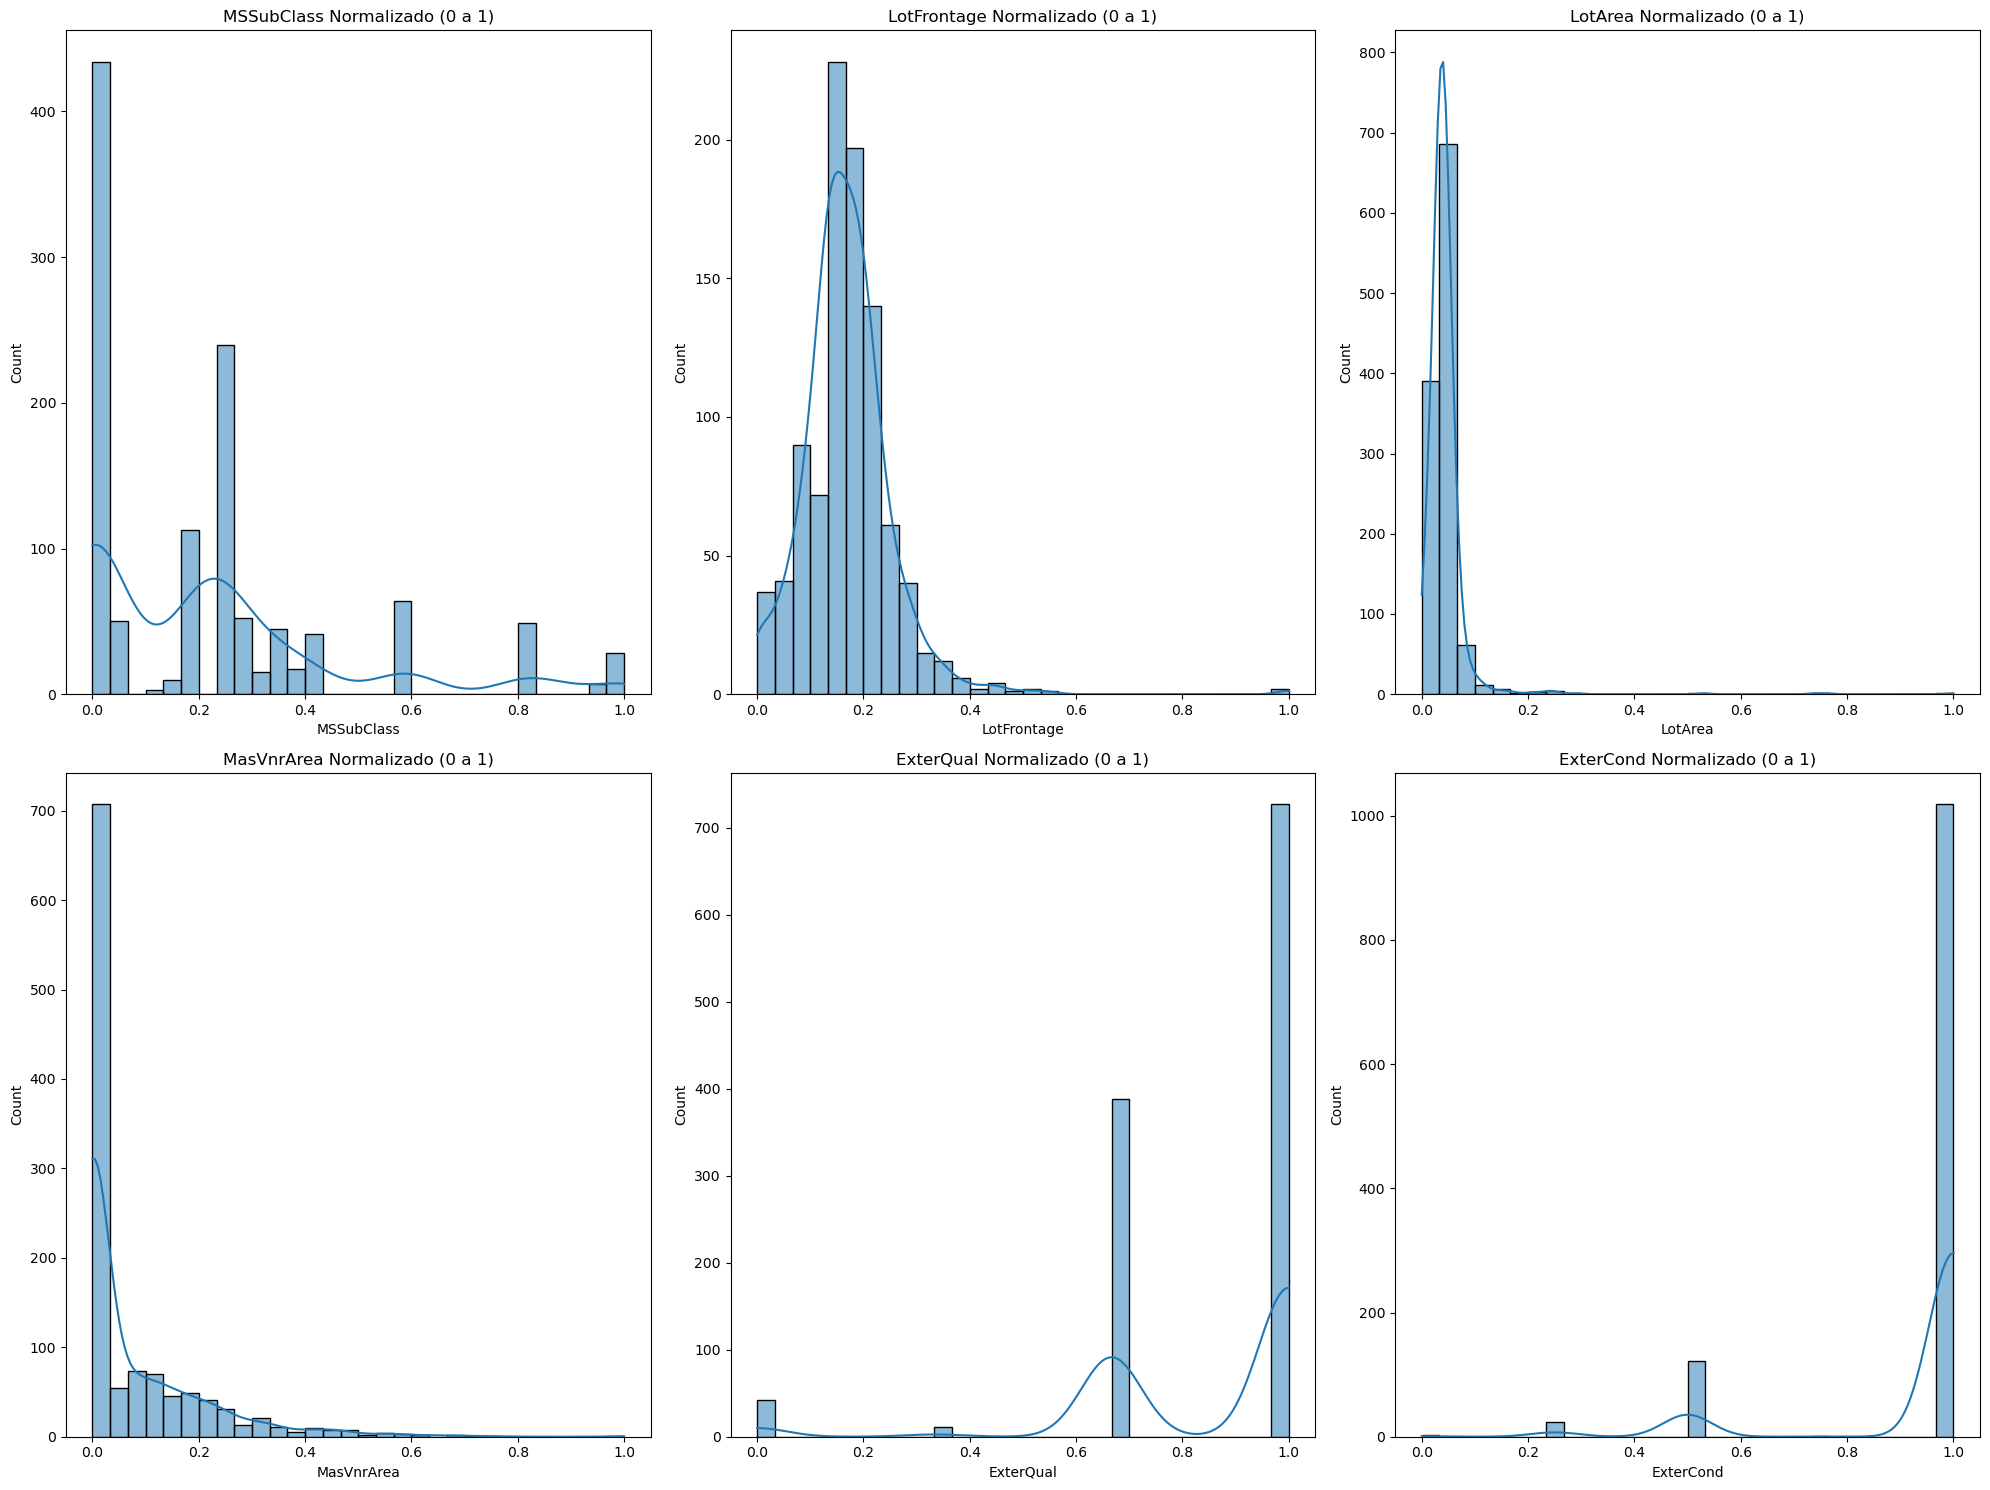

{'Resumen Estandarización':         OverallQual   OverallCond     YearBuilt  YearRemodAdd     BsmtUnfSF  \
 count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
 mean  -5.170902e-17 -2.281280e-16 -1.417435e-15  4.653812e-15  5.322987e-17   
 std    1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00   
 min   -3.746488e+00 -4.109739e+00 -3.227597e+00 -1.683818e+00 -1.278864e+00   
 25%   -8.204446e-01 -5.241741e-01 -5.859221e-01 -9.118065e-01 -7.801788e-01   
 50%   -8.893368e-02 -5.241741e-01  3.373017e-02  4.392138e-01 -2.030489e-01   
 75%    6.425772e-01  3.722173e-01  9.795152e-01  9.217210e-01  5.371341e-01   
 max    2.837110e+00  3.061391e+00  1.273035e+00  1.211225e+00  3.956768e+00   
 
           HeatingQC      2ndFlrSF  BsmtFullBath      FullBath      HalfBath  \
 count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
 mean   1.825024e-17  4.562560e-18 -7.832395e-17 -5.475072e-17 -1.140640e-16   
 std    1.0

In [15]:
# Identificamos variables con distribución normal y sesgada
# Usando el criterio de sesgo: Si el skew es > 1 o < -1, se considera sesgada

dist_normal = []
dist_sesgada = []

for col in numerical_vars:
    skewness = skew(df_train_transformed[col].dropna())
    if abs(skewness) > 1:
        dist_sesgada.append(col)
    else:
        dist_normal.append(col)

# Aplicar estandarización a variables con distribución normal
df_train_standardized = df_train_transformed.copy()
df_train_standardized[dist_normal] = standard_scaler.fit_transform(df_train_transformed[dist_normal])

# Aplicar normalización a variables con distribución sesgada
df_train_one_hot_encoded = df_train_transformed.copy()
df_train_one_hot_encoded[dist_sesgada] = min_max_scaler.fit_transform(df_train_transformed[dist_sesgada])

# 3. Verificación de Resultados
# Comprobar la media y desviación estándar en estandarización
standard_summary = df_train_standardized[dist_normal].describe()

# Comprobar los límites de 0 a 1 en normalización
normalized_summary = df_train_one_hot_encoded[dist_sesgada].describe()

# 4. Visualización después de la transformación
# Estandarización (Distribución Normal)
plt.figure(figsize=(20, 15))
for i, col in enumerate(dist_normal[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_standardized[col], bins=30, kde=True)
    plt.title(f'{col} Estandarizado (Media 0, Desv. Est. 1)')
plt.tight_layout()
plt.show()

# Normalización (Distribución Sesgada)
plt.figure(figsize=(20, 15))
for i, col in enumerate(dist_sesgada[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_one_hot_encoded[col], bins=30, kde=True)
    plt.title(f'{col} Normalizado (0 a 1)')
plt.tight_layout()
plt.show()

# Resultados
{
    "Resumen Estandarización": standard_summary,
    "Resumen Normalización": normalized_summary
}


Nos muestran cómo cambiaron las distribuciones de las variables después de aplicar estandarización y normalización.

**Los datos estandarizados (StandardScaler):**

* Se ven más centrados en torno a 0.
* La forma de la distribución se mantiene.
* Es útil para modelos como Regresión Lineal y SVM, que funcionan mejor con datos centrados.

**Los datos normalizados (MinMaxScaler):**

* Ahora todos los valores están en un rango de 0 a 1.
* Se evita que valores grandes (como LotArea) dominen el modelo.
* Es útil para modelos basados en distancia (KNN, Clustering).

### Análisis descriptivo

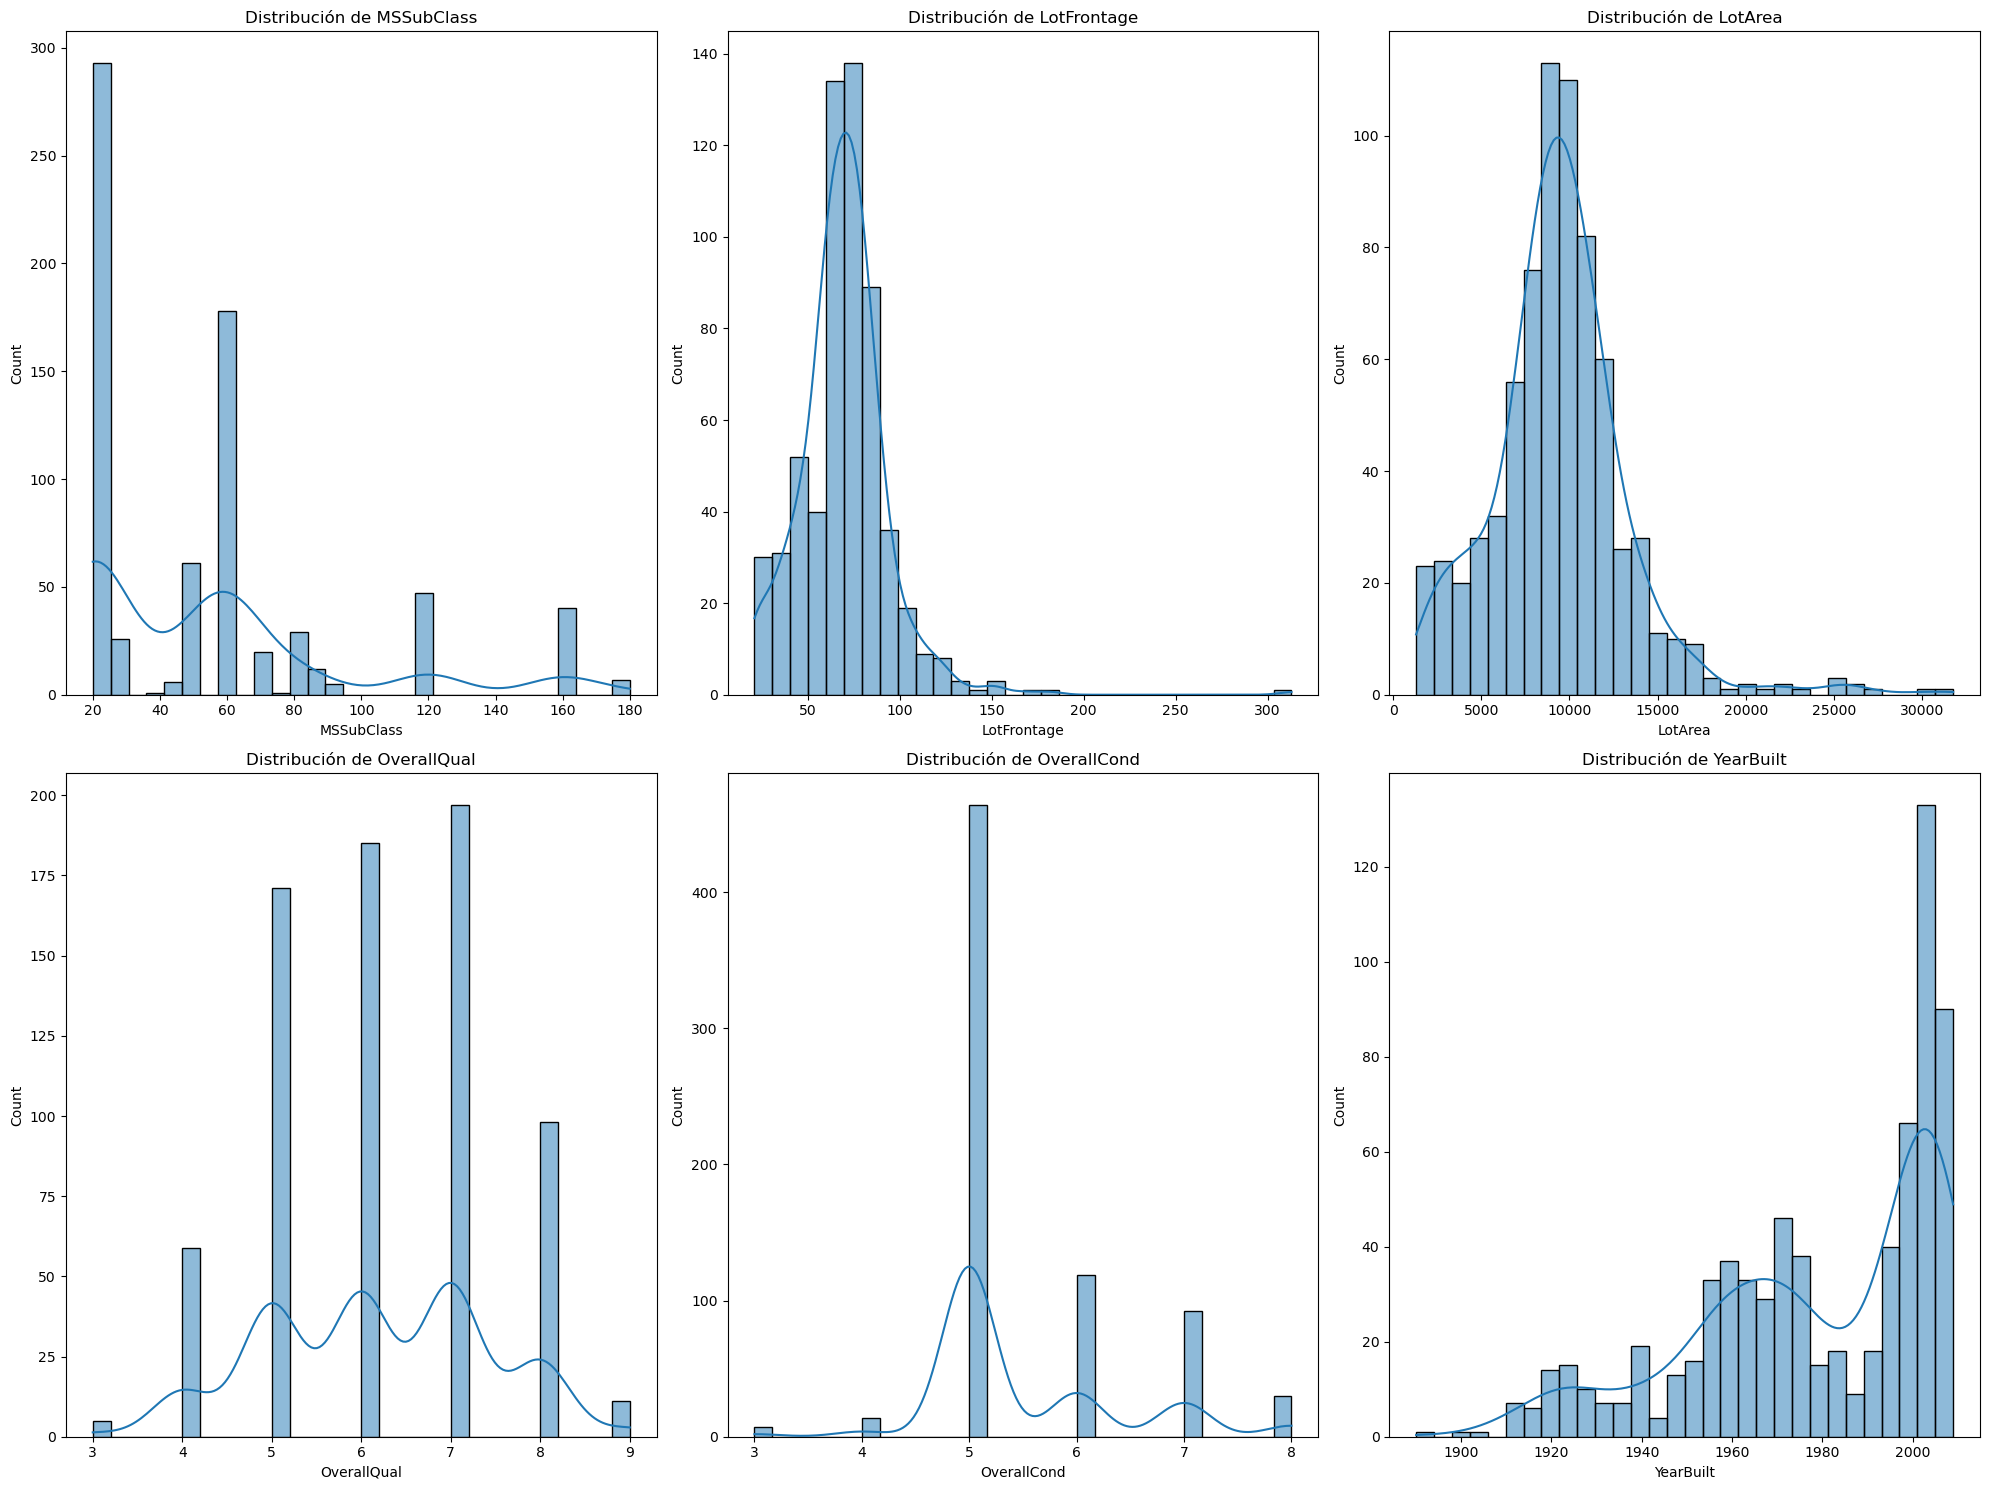

,Media,Mediana,Moda,Desviación Estándar,Varianza,Rango,Percentil 25,Percentil 50 (Mediana),Percentil 75
MSSubClass,54.056474,50.0,20.0,40.175970,1.614109e+03,160.0,20.0,50.0,60.00
LotFrontage,69.511745,70.0,60.0,24.466163,5.985931e+02,292.0,59.0,70.0,80.00
LotArea,9430.174931,9327.0,9600.0,3893.626117,1.516032e+07,30470.0,7388.5,9327.0,11213.00
OverallQual,6.168044,6.0,7.0,1.242633,1.544136e+00,6.0,5.0,6.0,7.00
OverallCond,5.502755,5.0,5.0,0.921389,8.489579e-01,5.0,5.0,5.0,6.00
YearBuilt,1978.606061,1984.0,2005.0,27.015534,7.298391e+02,119.0,1960.0,1984.0,2003.00
YearRemodAdd,1987.316804,1997.0,1950.0,20.056580,4.022664e+02,60.0,1970.0,1997.0,2004.75
MasVnrArea,92.697222,0.0,0.0,150.546395,2.266422e+04,975.0,0.0,0.0,151.50
ExterQual,2.570248,3.0,3.0,0.503666,2.536791e-01,2.0,2.0,3.0,3.00
ExterCond,3.826446,4.0,4.0,0.563404,3.174238e-01,2.0,4.0,4.0,4.00


In [16]:
# Identificación de variables numéricas
numerical_vars = df_train_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Cálculo de medidas estadísticas
medidas = pd.DataFrame(index=numerical_vars)

# Media
medidas['Media'] = df_train_cleaned[numerical_vars].mean()

# Mediana
medidas['Mediana'] = df_train_cleaned[numerical_vars].median()

# Moda (puede haber más de una, así que tomamos la primera)
medidas['Moda'] = df_train_cleaned[numerical_vars].mode().iloc[0]

# Desviación Estándar
medidas['Desviación Estándar'] = df_train_cleaned[numerical_vars].std()

# Varianza
medidas['Varianza'] = df_train_cleaned[numerical_vars].var()

# Rango
medidas['Rango'] = df_train_cleaned[numerical_vars].max() - df_train_cleaned[numerical_vars].min()

# Percentiles
medidas['Percentil 25'] = df_train_cleaned[numerical_vars].quantile(0.25)
medidas['Percentil 50 (Mediana)'] = df_train_cleaned[numerical_vars].quantile(0.50)
medidas['Percentil 75'] = df_train_cleaned[numerical_vars].quantile(0.75)

# Visualización de distribuciones
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_vars[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_train_cleaned[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Mostrar resumen de medidas estadísticas
medidas.head(10)


### Visualización de datos
Se hace la visualización de los datos para mayor análisis. Asimismo, se determina las variables que puedan ser útiles para predecir los precios.

### Matriz de correlación 

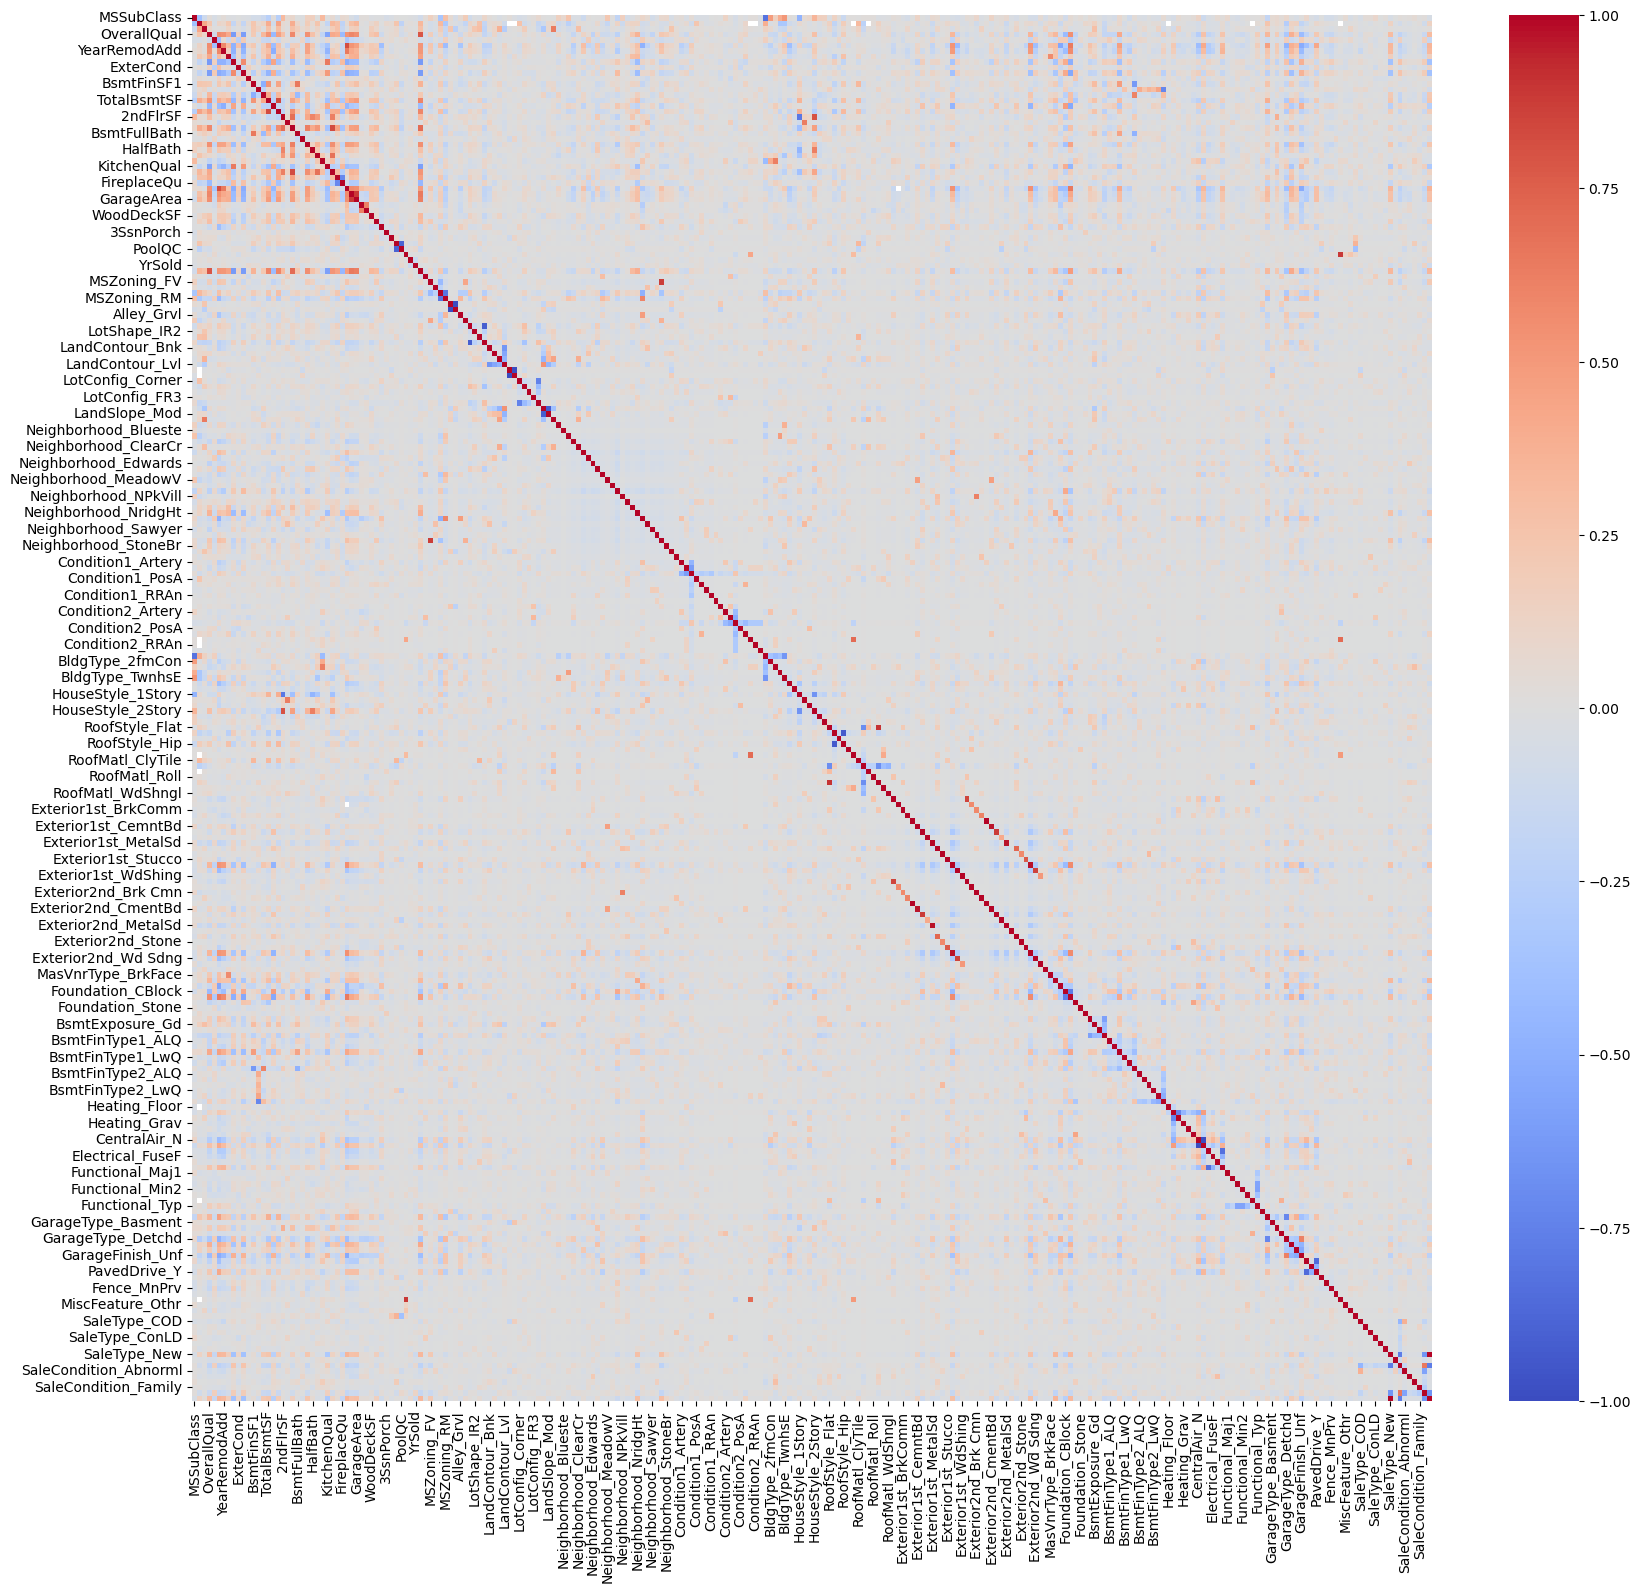

In [17]:
# matriz de correlación con todas las variables estandarizadas. Poco legible y no nos dice mucho.
correlation_matrix = df_train_standardized.corr()
plt.figure(figsize=(20, 18)) 
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

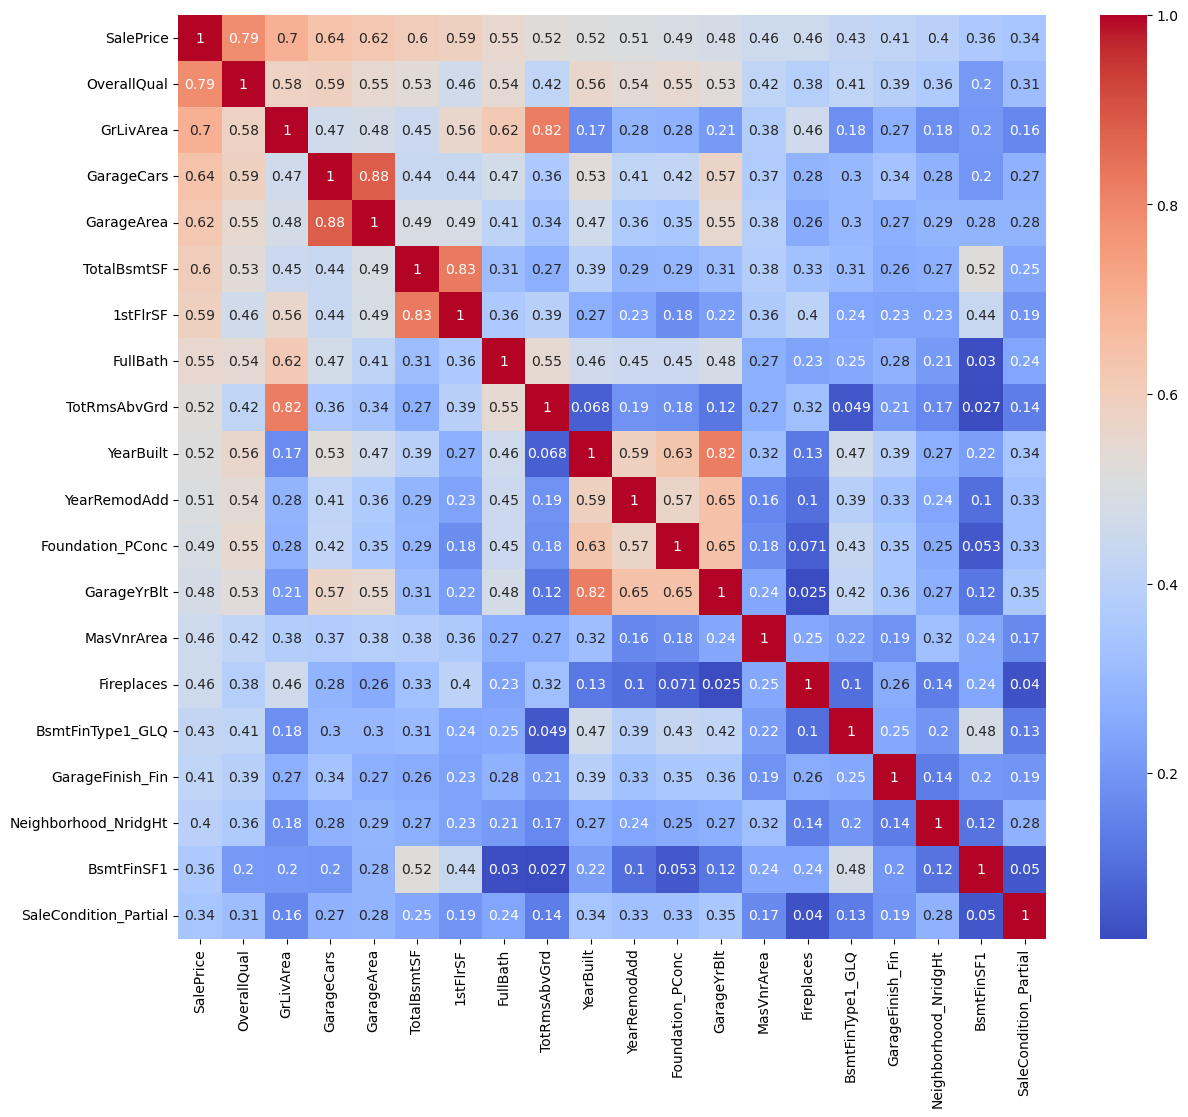

In [18]:
# Matriz de correlación para las variables mayormente asociadas con SalePrice utilizando estandarización
sale_price_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)
# Eligimos las un estimado de las top 20; puede cambiarse este número
top_features = sale_price_correlation.index[:20]

correlation_matrix_qual = df_train_standardized[top_features].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_qual, annot=True, cmap='coolwarm')

plt.show()

### Variables para estimar precio

Determinar el precio de una propiedad depende de varios factores. Si estimamos basado en una pequeña búsqueda en línea; con los siguientes sitios web:
- [CompassMortage](https://www.compmort.com/what-determines-the-value-of-a-home/)
- [GoodMove](https://goodmove.co.uk/blog/the-5-key-factors-that-determine-your-house-market-value/)
- [Experian](https://www.experian.com/blogs/ask-experian/factors-that-affect-home-value/)

Se llega a que los factores más relevantes son:
- Ubicación 
- Condición y edad del hogar
- Tamaño
- Precios de casas circundantes

Idealmente sería mejor consultar con un experto el precio de una casa, mas no contamos con un expero a disposición. Por lo tanto, se tomó como fuente empresas de bienes raíces:
- [FORSALEbyOwner](https://www.forsalebyowner.com/blog/how-to-get-an-accurate-valuation-part-1)
- [Realtor](https://www.realtor.com/advice/sell/how-to-price-a-home-in-sellers-market/)
- [Zillow](https://www.zillow.com/learn/how-to-price-home-to-sell/)

Obtenemos un poco más de información respecto a las variables y consideraciones a la hora de estimar el valor de una propiedad. 
- Fecha de construcción (edad de la casa).
- Dimensiones del hogar $m^2$; número de habitaciones, baños, cubículos, etc.
- Remodelaciones, renovaciones o trabajos hechos a la propiedad.
- Ubicaicón de la propiedad
- Amenidades (i.e seguridad, jardín, etc)
- Precio de servicios 
- Precios recientes de propiedades circundantes
- Tendencias del mercado y condiciones económicas

Lo anterior dicho ya trranscrito en las variables que tenemos para utilizar nos resulte en las siguientes variables:

* OverallQual
* GrLivArea
* tTotalBsmtSF
* GarageCars
* GarageArea
* 1stFlrSF
* FullBath
* TotRmsAbcGrd



### Pruebas de normalidad y correlación

### Análisis de agrupamiento

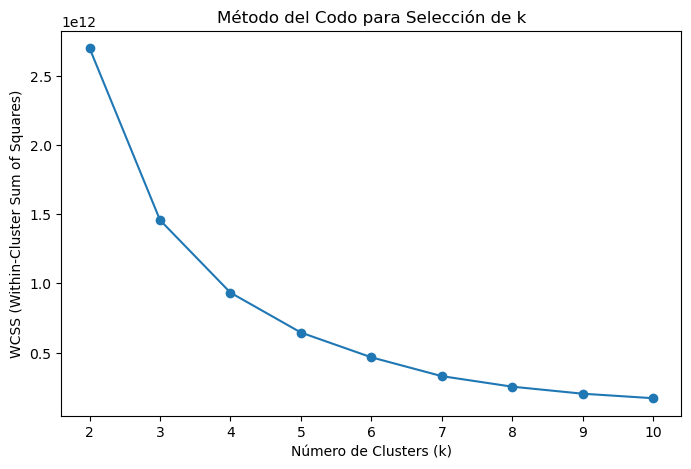

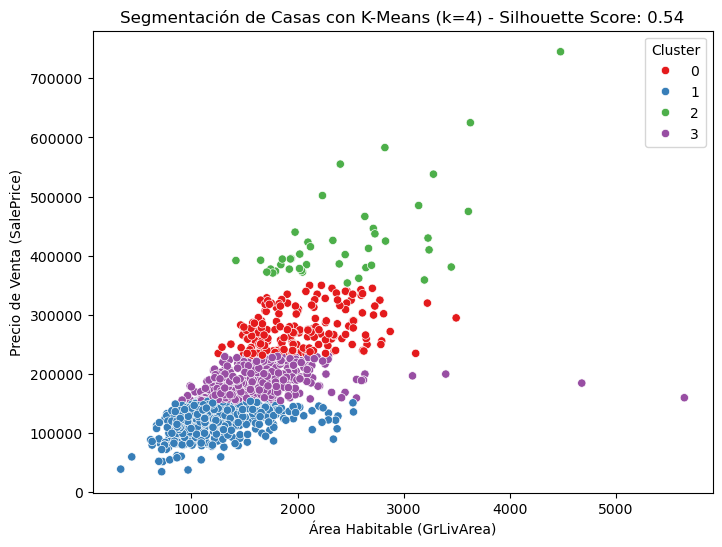

   Cluster  Cantidad de Casas
0        1                504
1        3                435
2        0                186
3        2                 43


In [19]:
# Selección de variables para clustering (usamos las más relevantes según correlación)
clustering_vars = ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageCars", "SalePrice"]
df_clustering = df_train_standardized[clustering_vars]

# Determinar el número óptimo de clusters con el método del codo
wcss = []  # Suma de los cuadrados de las distancias intra-cluster
for k in range(2, 11):  # Probamos con k desde 2 hasta 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_clustering)
    wcss.append(kmeans.inertia_)  # Guardamos la métrica de inercia

# Graficar el método del codo para elegir k
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='-')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Método del Codo para Selección de k")
plt.show()

# Aplicar K-Means con el número óptimo de clusters (según la gráfica)
optimal_k = 4  # Puedes ajustar este valor después de revisar la gráfica
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clustering = df_train_standardized[clustering_vars].copy() 
df_clustering["Cluster"] = kmeans.fit_predict(df_clustering)

# Evaluar la calidad del clustering con la métrica de silueta
silhouette_avg = silhouette_score(df_clustering[clustering_vars], df_clustering["Cluster"])

# Visualizar los clusters en un gráfico de dispersión 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clustering["GrLivArea"], y=df_clustering["SalePrice"], hue=df_clustering["Cluster"], palette="Set1")
plt.xlabel("Área Habitable (GrLivArea)")
plt.ylabel("Precio de Venta (SalePrice)")
plt.title(f"Segmentación de Casas con K-Means (k={optimal_k}) - Silhouette Score: {silhouette_avg:.2f}")
plt.legend(title="Cluster")
plt.show()

# Mostrar cuántas casas hay en cada cluster
cluster_counts = df_clustering["Cluster"].value_counts().reset_index()
cluster_counts.columns = ["Cluster", "Cantidad de Casas"]

# Mostrar resultados en tabla
print(cluster_counts)



## Ingeniería de Características

### Selección de variables relevantes

En base a las variables que parecen estar fuertemente relacionadas con el SalePrice de la casa:

* OverallQual
* GrLivArea
* tTotalBsmtSF
* GarageCars
* GarageArea
* 1stFlrSF
* FullBath
* TotRmsAbcGrd

Se realizará un análisis de ellas para poder obtener datos más relevantes.

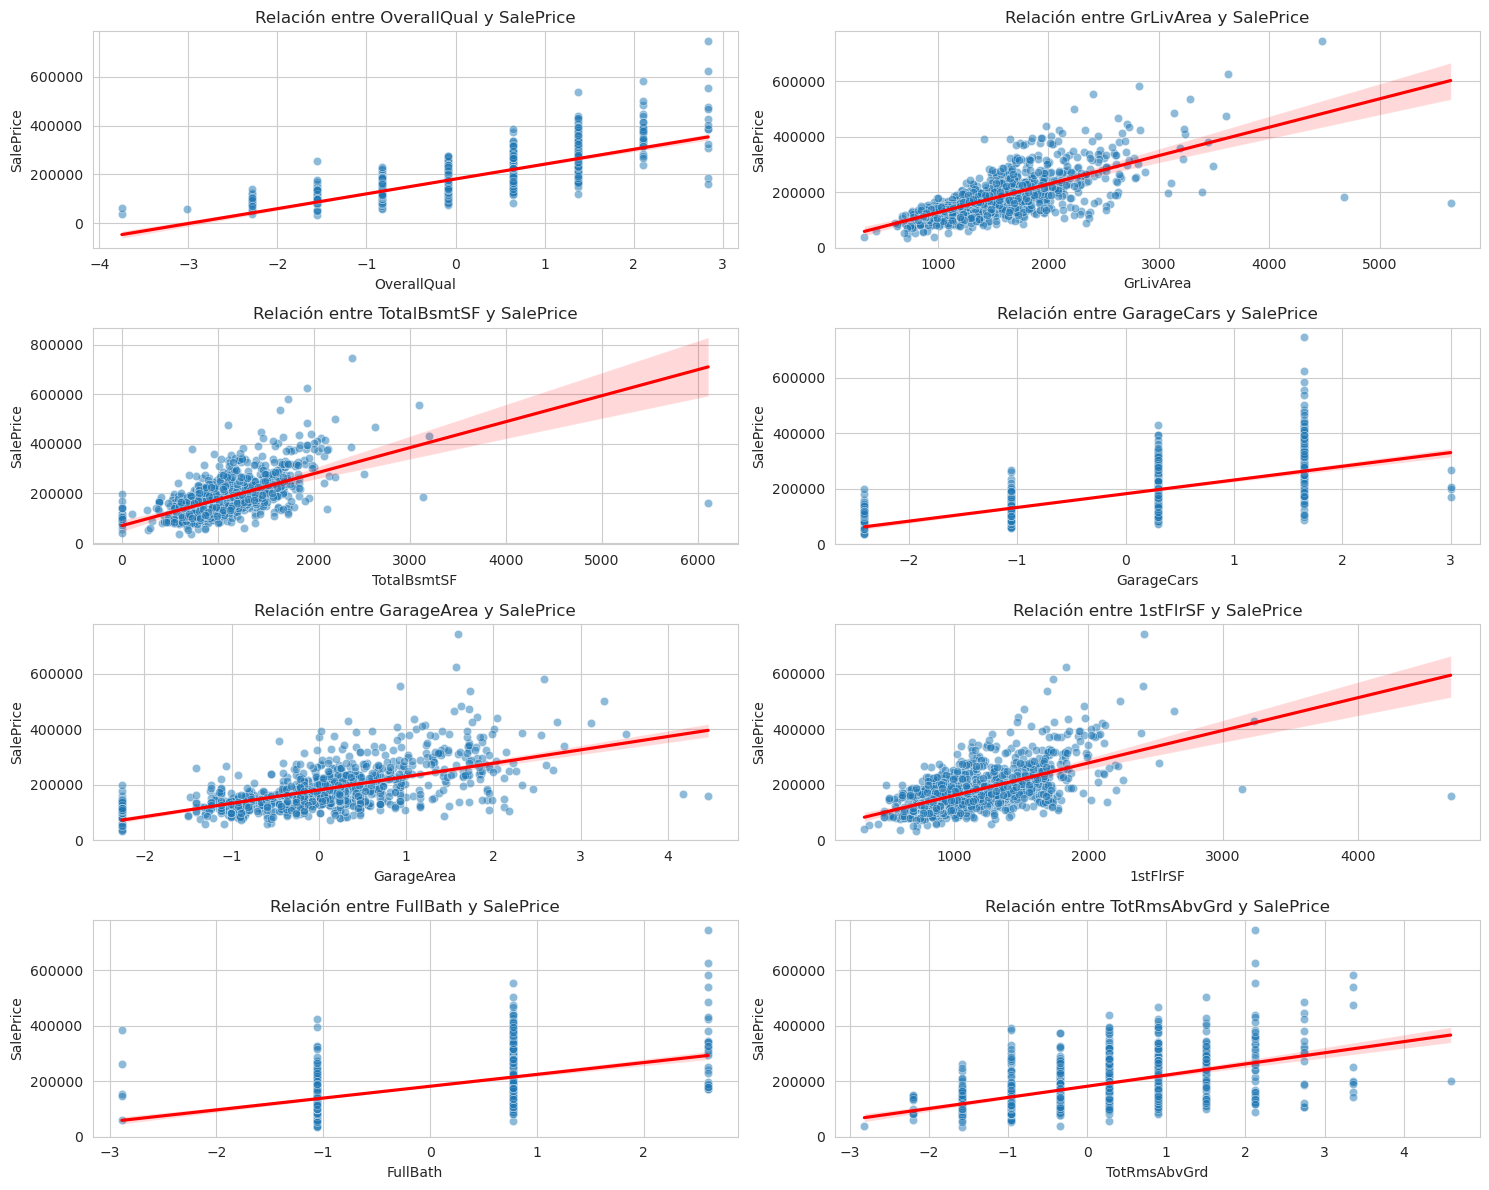

In [20]:
#Variables relevantes
variables = ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageCars", 
             "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]

sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(x=df_train_standardized[var], y=df_train_standardized["SalePrice"], alpha=0.5)
    sns.regplot(x=df_train_standardized[var], y=df_train_standardized["SalePrice"], scatter=False, color="red")  # Línea de tendencia
    plt.title(f"Relación entre {var} y SalePrice")

plt.tight_layout()
plt.show()

Entre estas variables, las que se encuentran más fuertemente correlacionadas con SalePrice son OverallQual, GrLivArea, totalBsmtSF y 1stFlrSF. Entre las variables seleccionadas, se pueden observar algunos outliers.

### Correlación utilizando Pearson y Spearman
Por medio del analisis de correlaciones con Spearman podemos medir que tan bien una variable sigue ya sea una tendencia creciente o decreciente sin tener una relación exactamente lineal, mientras que Pearson nos ayuda a evaluar la relación lineal.

In [21]:
import scipy.stats as skew  # Renombraste stats como skew

print("\n🔹 Correlación con SalePrice:")

for var in variables:
    pearson_corr, pearson_p = skew.pearsonr(df_train_standardized[var], df_train_standardized["SalePrice"])  
    spearman_corr, spearman_p = skew.spearmanr(df_train_standardized[var],df_train_standardized["SalePrice"])  

    print(f"{var}: Pearson r={pearson_corr:.3f} (p={pearson_p:.5f}), Spearman r={spearman_corr:.3f} (p={spearman_p:.5f})")



🔹 Correlación con SalePrice:
OverallQual: Pearson r=0.786 (p=0.00000), Spearman r=0.801 (p=0.00000)
GrLivArea: Pearson r=0.696 (p=0.00000), Spearman r=0.723 (p=0.00000)
TotalBsmtSF: Pearson r=0.598 (p=0.00000), Spearman r=0.595 (p=0.00000)
GarageCars: Pearson r=0.641 (p=0.00000), Spearman r=0.687 (p=0.00000)
GarageArea: Pearson r=0.624 (p=0.00000), Spearman r=0.639 (p=0.00000)
1stFlrSF: Pearson r=0.588 (p=0.00000), Spearman r=0.566 (p=0.00000)
FullBath: Pearson r=0.553 (p=0.00000), Spearman r=0.626 (p=0.00000)
TotRmsAbvGrd: Pearson r=0.520 (p=0.00000), Spearman r=0.521 (p=0.00000)


Las variables que muestran una fuerte correlacion positiva (siendo esto r>0.6) son OverallQual, GrLIveArea, GarageCars y GarageArea. Esto nos da a indicar las casas de mejor calidad suelen valer más al igual que las casas con mayor área habitable y el espacio de garage.

### Modelo univariado


En este caso se creará un modelo univariado de regresión lineal para predecir el precio de las casas. 
La variable elegida será `OverallQual`.

In [22]:
df_test = pd.read_csv('data/test_set.csv') # cargar el set de prueba

In [23]:
df_test.describe() # ver datos

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,292.000000,250.000000,292.000000,292.000000,292.000000,292.000000,292.000000,290.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,57.089041,68.932000,9825.571918,6.010274,5.537671,1972.476027,1984.739726,103.337931,434.102740,52.136986,...,87.434932,34.986301,22.414384,1.797945,13.674658,1.972603,12.376712,6.184932,2007.804795,178839.811644
std,41.433741,21.809309,5886.343498,1.441850,1.100743,28.251377,20.321997,210.539173,444.652028,173.346231,...,106.111686,50.049184,57.199562,17.941206,55.333233,33.707850,79.339770,2.832078,1.351941,87730.751259
min,20.000000,21.000000,1491.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,59.000000,7315.000000,5.000000,5.000000,1955.000000,1968.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,127000.000000
50%,50.000000,66.500000,9008.500000,6.000000,5.000000,1975.000000,1992.000000,0.000000,374.000000,0.000000,...,26.000000,13.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,154150.000000
75%,70.000000,80.000000,11256.250000,7.000000,6.000000,1999.000000,2003.250000,147.250000,685.250000,0.000000,...,168.000000,53.250000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,209175.000000
max,190.000000,174.000000,70761.000000,10.000000,9.000000,2009.000000,2010.000000,1600.000000,2188.000000,1474.000000,...,466.000000,274.000000,318.000000,238.000000,396.000000,576.000000,600.000000,12.000000,2010.000000,755000.000000


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# especificar los datos de entrenamiento
X_train = df_train_cleaned[['OverallQual']]
Y_train = df_train_cleaned['SalePrice']

# especificar los datos de testing
X_test = df_test[['OverallQual']]
Y_test = df_test['SalePrice']

model = LinearRegression() # instanciar el modelo
model.fit(X=X_train, y=Y_train) # entrenar

print("Coeficiente: ", model.coef_[0])
print("Intercepto: ", model.intercept_)

Coeficiente:  39056.09967567119
Intercepto:  -62463.70158079284


In [25]:
# realizar predicciones
Y_pred = model.predict(X_test)


In [26]:
# comparar con los datos de test
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("MSE: ", mse)
print("R^2: ", r2)

MSE:  2887053413.2693725
R^2:  0.6236074796187687


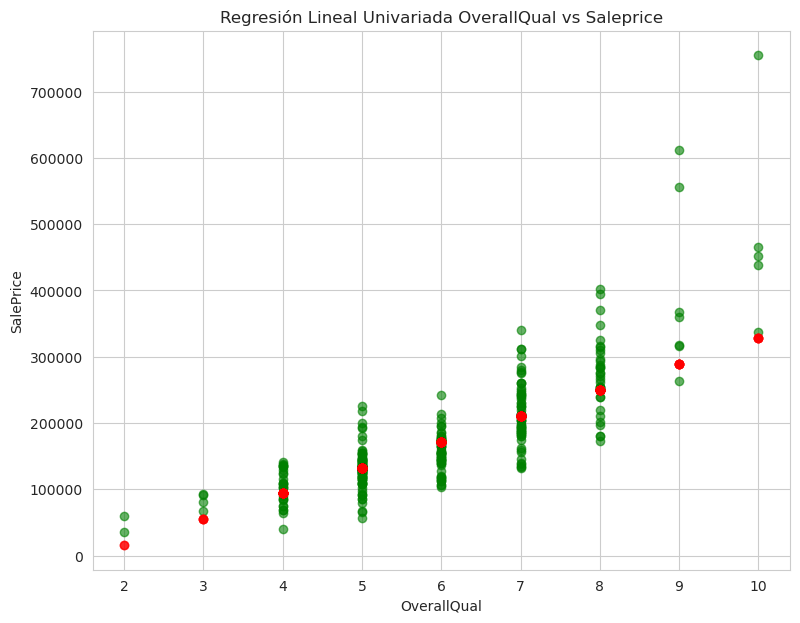

In [27]:
# visualizar los datos
plt.figure(figsize=(9, 7))
plt.scatter(X_test, Y_test, color='green', label='Valores Reales', alpha=0.6)
plt.scatter(X_test, Y_pred, color='red', label='Valores Predichos', alpha=0.6)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('Regresión Lineal Univariada OverallQual vs Saleprice')
plt.show()

### Modelo multivariable

In [28]:
# seleccionar todas las variables numéricas 
numeric_cols = df_train_transformed.select_dtypes(['int64', 'float64']).columns
numeric_features = numeric_cols.drop(['PoolQC', 'HeatingQC', 'BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'], errors='ignore')  # in case target isn't in numeric_cols
print(numeric_features)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [29]:

X_train_mult = df_train_transformed[numeric_features].copy()
Y_train_mult = df_train_transformed['SalePrice'].copy()

X_test_mult = df_test[numeric_features].copy()
Y_test_mult = df_test['SalePrice'].copy()

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') # instanciar con acercamiento de mediana
X_train_mult_imp = imputer.fit_transform(X_train_mult)

X_test_mult_imp = imputer.fit_transform(X_test_mult)


X_train_mult = pd.DataFrame(X_train_mult_imp,  columns=X_train_mult.columns, index=X_train_mult.index)
X_test_mult = pd.DataFrame(X_test_mult_imp, columns=X_test_mult.columns, index=X_test_mult.index)



In [31]:
model_multivariable = LinearRegression() # instanciar el modelo
model_multivariable.fit(X_train_mult, Y_train_mult)
coef_dict = pd.Series(model_multivariable.coef_, index=X_train_mult.columns)
print(f"Coeficientes: {coef_dict.sort_values(ascending=False)}")


Coeficientes: SalePrice        1.000000e+00
KitchenAbvGr     1.677676e-11
BedroomAbvGr     1.624196e-11
HalfBath         4.306439e-12
BsmtHalfBath     2.038959e-12
YrSold           9.775209e-13
MoSold           3.070442e-13
MSSubClass       2.630161e-13
PoolArea         3.949646e-14
GarageArea       8.070801e-15
BsmtFinSF2       6.762603e-15
MiscVal          1.592314e-15
LowQualFinSF     1.256211e-15
BsmtUnfSF        4.614364e-16
LotArea         -6.383782e-16
EnclosedPorch   -8.390722e-15
OpenPorchSF     -1.300616e-14
TotalBsmtSF     -1.490995e-14
1stFlrSF        -2.150884e-14
BsmtFinSF1      -2.220793e-14
2ndFlrSF        -3.706757e-14
MasVnrArea      -5.295889e-14
WoodDeckSF      -5.331093e-14
GrLivArea       -5.719990e-14
3SsnPorch       -9.172486e-14
ScreenPorch     -1.255865e-13
GarageYrBlt     -2.522752e-13
YearRemodAdd    -3.169174e-13
YearBuilt       -6.059207e-13
LotFrontage     -6.870060e-13
FullBath        -5.418966e-12
OverallCond     -8.987897e-12
TotRmsAbvGrd    -9.268802e

In [32]:

# predecir
Y_pred_mult = model_multivariable.predict(X_test_mult)


In [33]:

mse = mean_squared_error(Y_test_mult, Y_pred_mult)
r2  = r2_score(Y_test_mult, Y_pred_mult)

print("MSE: ", mse)
print("RMSE: ", mse**0.5)
print("R^2: ", r2)


MSE:  1.0165664466073603e-20
RMSE:  1.008249198664378e-10
R^2:  1.0


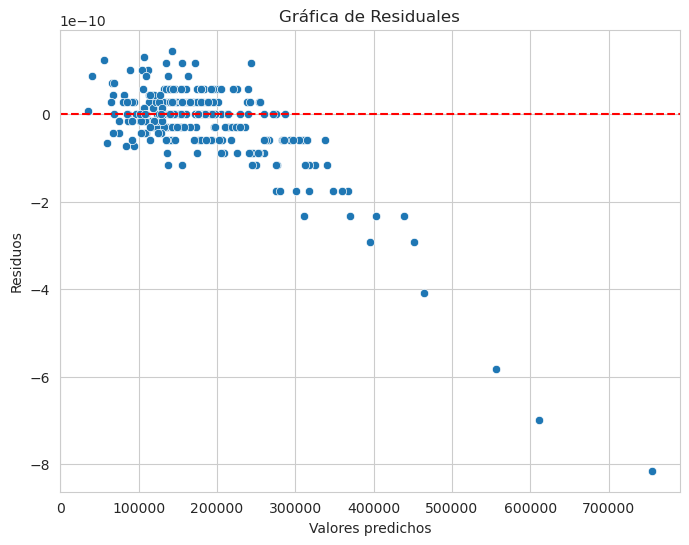

In [34]:
# graficar los residuos
residuals = Y_test_mult - Y_pred_mult

plt.figure(figsize=(8,6))
sns.scatterplot(x=Y_pred_mult, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Gráfica de Residuales")
plt.show()


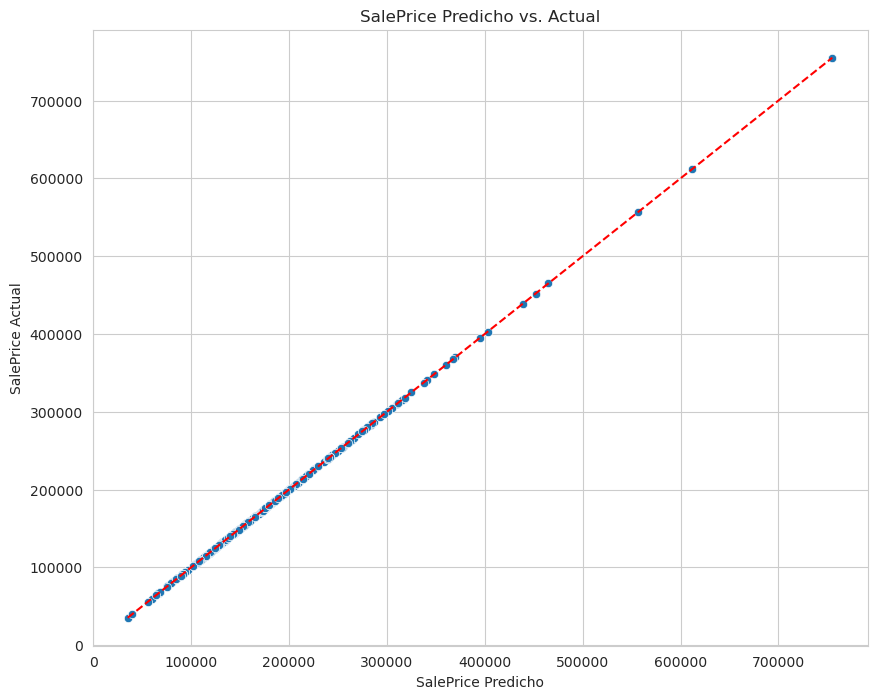

In [35]:

# gráfica
plt.figure(figsize=(10,8))
sns.scatterplot(x=Y_pred_mult, y=Y_test_mult)
plt.xlabel('SalePrice Predicho')
plt.ylabel('SalePrice Actual')
plt.title('SalePrice Predicho vs. Actual')
max_val = max(Y_pred_mult.max(), Y_test_mult.max())
min_val = min(Y_pred_mult.min(), Y_test_mult.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.show()

### Creación de nuevas características

### Análisis de multicolinealidad

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Función para calcular el VIF antes de aplicar Ridge
def calcVIF(X, filename="vif_results_before_ridge.txt"):
  data = pd.DataFrame()
  data["Variable"] = X.columns
  data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  # Clasificación de variables según VIF
  high_vif = data[data["VIF"] > 10]
  moderate_vif = data[(data["VIF"] >= 5) & (data["VIF"] <= 10)]
  low_vif = data[data["VIF"] < 5]

  # Guardamos los resultados en un archivo
  with open(filename, "w", encoding="utf-8") as f:
    f.write("VIF por cada variable antes de Ridge:\n")
    f.write(data.sort_values(by="VIF", ascending=False).to_string(index=False))

    f.write("\n\nResumen:\n")
    f.write(f"Variables con VIF > 10 (Alta multicolinealidad): {len(high_vif)}\n")
    f.write(high_vif.to_string(index=False))

    f.write(f"\n\nVariables con 5 ≤ VIF ≤ 10 (Multicolinealidad moderada): {len(moderate_vif)}\n")
    f.write(moderate_vif.to_string(index=False))

    f.write(f"\n\nVariables con VIF < 5 (Sin problemas de multicolinealidad): {len(low_vif)}\n")
    f.write(low_vif.to_string(index=False))

  print(f"Resultados guardados en {filename}")

# Ejecutar la función para calcular VIF antes de Ridge
calcVIF(X_train_mult, "vif_results_before_ridge.txt")

ModuleNotFoundError: No module named 'statsmodels'


Resultados del Modelo Ridge con Alpha=100:
MSE: 7.433843036617047e-14
R²: 1.0


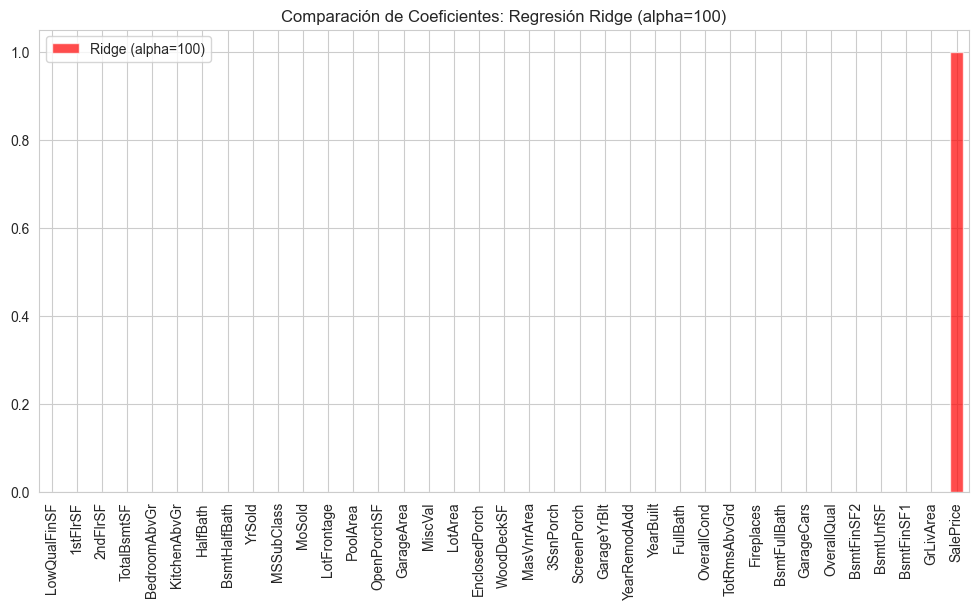

d:\UVG GitHub Repositorios\2025\CC_3074_Proyecto_2\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Resultados guardados en vif_results_after_ridge.txt


In [ ]:
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor

ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_mult, Y_train_mult)

# Predicciones con Ridge
Y_pred_ridge = ridge_model.predict(X_test_mult)

# Evaluamos el modelo Ridge
mse_ridge = mean_squared_error(Y_test_mult, Y_pred_ridge)
r2_ridge = r2_score(Y_test_mult, Y_pred_ridge)

print("\nResultados del Modelo Ridge con Alpha=100:")
print("MSE:", mse_ridge)
print("R²:", r2_ridge)

# Extraer coeficientes de Ridge
coef_ridge = pd.Series(ridge_model.coef_, index=X_train_mult.columns)

# Graficar comparación de coeficientes
plt.figure(figsize=(12, 6))
coef_ridge.sort_values().plot(kind="bar", label="Ridge (alpha=100)", alpha=0.7, color='red')
plt.legend()
plt.title("Comparación de Coeficientes: Regresión Ridge (alpha=100)")
plt.show()

X_train_ridge = pd.DataFrame(ridge_model.predict(X_train_mult), columns=['Ridge_Pred'])
X_train_ridge = pd.concat([X_train_ridge, X_train_mult], axis=1)

X_train_ridge = X_train_ridge.replace([np.inf, -np.inf], np.nan).dropna()

# Función para calcular VIF después de Ridge
def calcVIF_fixed(X, filename="vif_results_after_ridge.txt"):
  data = pd.DataFrame()
  data["Variable"] = X.columns
  data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  # Guardar los resultados en un archivo
  with open(filename, "w", encoding="utf-8") as f:
    f.write("VIF por cada variable después de Ridge (Alpha=100):\n")
    f.write(data.sort_values(by="VIF", ascending=False).to_string(index=False))

  print(f"Resultados guardados en {filename}")

calcVIF_fixed(X_train_ridge, "vif_results_after_ridge.txt")


In [37]:
df_train_standardized.to_csv("standarized_df.csv", index=False)